<a href="https://colab.research.google.com/github/Jack3690/Kugelblitz/blob/main/MaNGA_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialization**

In [1]:
!pip install sdss-marvin --quiet
!pip install photutils --quiet

     |████████████████████████████████| 414 kB 2.1 MB/s 
     |████████████████████████████████| 57 kB 5.0 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 40 kB 5.7 MB/s 
     |████████████████████████████████| 284 kB 51.0 MB/s 
     |████████████████████████████████| 351 kB 65.4 MB/s 
     |████████████████████████████████| 49 kB 3.0 MB/s 
     |████████████████████████████████| 525 kB 55.7 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 1.3 MB 48.4 MB/s 
     |████████████████████████████████| 166 kB 49.6 MB/s 
     |████████████████████████████████| 100 kB 10.2 MB/s 
     |████████████████████████████████| 170 kB 47.0 MB/s 
     |████████████████████████████████| 2.2 MB 33.7 MB/s 
     |████████████████████████████████| 548 kB 51.1 MB/s 
     |████████████████████████████████| 216 kB 60.7 MB/s 
     |████████████████████████████████| 41 kB 355 kB/s 
     |█████████████████████

In [2]:
!pip install pafit --quiet

In [3]:
!git clone https://github.com/Jack3690/Kugelblitz

Cloning into 'Kugelblitz'...
remote: Enumerating objects: 672, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 672 (delta 195), reused 270 (delta 163), pack-reused 358
Receiving objects: 100% (672/672), 222.55 MiB | 20.35 MiB/s, done.
Resolving deltas: 100% (353/353), done.


In [4]:
cd /content/Kugelblitz/

/content/Kugelblitz


# **Imports**

In [5]:
import os
import sys
import requests
import warnings
import PIL
import copy
from astropy.io import fits
if sys.version_info.major == 2:
    from cStringIO import StringIO as stringio
else:
    from io import StringIO as stringio
    from io import BytesIO as bytesio

In [6]:
!cp -a sas/map.py /usr/local/lib/python3.7/dist-packages/marvin/utils/plot/

In [112]:
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sb
import matplotlib
import numpy as np
from matplotlib import gridspec
import pandas as pd
import marvin.utils.plot.colorbar as colorbar
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
import photutils as phot
from photutils import isophote as iso
import os
import json

from marvin.tools.maps import Maps
import marvin.utils.plot.map as mapplot
from astropy.table import Table, join
import astropy.units as u
from astropy.io import ascii
from astropy.modeling import models,fitting
from scipy.interpolate import griddata
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import Planck15
from photutils import aperture as aper 
from astropy.coordinates import SkyCoord

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.wcs import WCS

from pafit import fit_kinematic_pa as paf

matplotlib.rcParams['figure.figsize']=(10,10)
matplotlib.rcParams['font.size']=15

sb.set_style('white')

In [8]:
from marvin import config
# set the release 
config.setRelease("DR17")

[WARNING]: path /root/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
  .format(value), MarvinUserWarning)

[WARNING]: path /root/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
  .format(value), MarvinUserWarning)



In [9]:
class Cutout_L(object):
    """ A Generic SDSS Cutout Image

    Tool which allows to generate an image using the SDSS Skyserver
    Image Cutout service.  See http://skyserver.sdss.org/public/en/help/docs/api.aspx#imgcutout
    for details.

    Parameters:
        ra (float):
            The central Right Ascension of the cutout
        dec (float):
            The central Declination of the cutout
        width (int):
           width of cutout in arcsec
        height (int):
            height in cutout in arcsec
        scale (float):
            pixel scale in arcsec/pixel.  Default is 0.262 "/pix.
 
    Attributes:
        rawurl (str):
            The raw url of the cutout
        wcs (WCS):
            The WCS of the generated image
        image (PIL.Image):
            The cutout image object
        size (int):
            The image size in arcsec
        size_pix (int):
            The image size in pixels
        center (tuple):
            The image center RA, Dec

    """

    def __init__(self, ra, dec, width, height, layers=None, scale=None, **kwargs):
        self.rawurl = ("https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}&pixscale={scale}&width={width_pix}&height={height_pix}&layer={layers}&bands=grz")
        self.ra = ra
        self.dec = dec
        self.scale = scale or 0.27  # default arcsec/pixel
        self.image = None
        self.layers = 'dr8-resid' if layers=='residual' else 'dr8'
        self.center = np.array([ra, dec])
        self.size   = np.array([width, height], dtype=int)
        self.coords = {'ra': ra, 'dec': dec,
                       'width': width, 'height': height,
                       'scale': self.scale
                      ,'layers':self.layers}
        self._get_pix_size()
        if np.max(self.size_pix) >= 2048:
            raise MarvinError('Requested image size is too large. '
                              'The Skyserver image cutout can only return a size up to 2048 pixels')

        self._define_wcs()
        self._get_cutout(**kwargs)

    def __repr__(self):
        return ('<Cutout (ra={0}, dec={1}, scale={2}, height={3}, '
                'width={4})>,layers={5}'.format(self.ra, self.dec, self.scale, *self.size_pix,self.layers))

    def _get_pix_size(self):
        """height,width converted from arcsec->pixels"""
        self.coords['height_pix'] = int(round(self.coords['height'] / self.scale))
        self.coords['width_pix'] = int(round(self.coords['width'] / self.scale))
        self.size_pix = np.array((self.coords['height_pix'], self.coords['width_pix']))

    def _define_wcs(self):
        """
        Given what we know about the scale of the image,
        define a nearly-correct world coordinate system to use with it.
        """
        w = WCS(naxis=2)
        w.wcs.crpix = self.size_pix / 2
        w.wcs.crval = self.center
        w.wcs.cd = np.array([[-1, 0], [0, 1]]) * self.scale / 3600.
        w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
        w.wcs.cunit = ['deg', 'deg']
        w.wcs.radesys = 'ICRS'
        w.wcs.equinox = 2000.0
        self.wcs = w

    def _wcs_to_dict(self):
        ''' Convert and return the WCS as a dictionary'''
        wcshdr = None
        if self.wcs:
            wcshdr = self.wcs.to_header()
            wcshdr = dict(wcshdr)
            wcshdr = {key: str(val) for key, val in wcshdr.items()}
        return wcshdr

    def _make_metadata(self, filetype=None):
        ''' Make the meta data for the image '''

        if 'png' in filetype:
            meta = PIL.PngImagePlugin.PngInfo()
        else:
            meta = None
            warnings.warn('Can only save WCS metadata with PNG filetype', MarvinUserWarning)

        if meta:
            info = {key: str(val) for key, val in self.image.info.items()}
            for row in info:
                meta.add_text(row, info[row])

        return meta

    def _update_info(self):
        ''' Update the image info dictionary '''

        for key, value in self.image.info.items():
            if isinstance(value, tuple):
                self.image.info[key] = value[0]

        wcsdict = self._wcs_to_dict()
        self.image.info = wcsdict
        self.image.info.update(self.coords)
        self.image.info['wdthpix'] = self.image.info.pop('width_pix')
        self.image.info['hghtpix'] = self.image.info.pop('height_pix')

    def _add_options(self, **kwargs):

        allowed = {'grid': 'G', 'label': 'L', 'photo': 'P', 'spectra': 'S',
                   'target': 'T', 'outline': 'O', 'bound': 'B', 'fields': 'F',
                   'masks': 'M', 'plates': 'Q', 'invert': 'I'}

        opts = []
        for key, value in kwargs.items():
            assert key in allowed.keys(), 'Cutout keyword must be one of: {0}'.format(allowed.keys())
            assert isinstance(value, (bool, type(None))), 'Cutout value can only be a Boolean'
            if value:
                opts.append(allowed[key])

        self.coords['opts'] = ''.join(opts)

    def _get_cutout(self, **kwargs):
        """ Gets an image cutout

        Get a cutout around a point, centered at some RA, Dec (in decimal
        degrees), and spanning width,height (in arcseconds) in size.

        Parameters:
            kwargs:
                Allowed keywords into the SDSS Skyserver Image Cutout

        """
        # add options
        self._add_options(**kwargs)
        # retrieve the image
        url = self.rawurl.format(**self.coords)
        response = requests.get(url)
        if not response.ok:
            print(f"\nImage not found for ra = {self.ra}, dec = {self.dec}\n" )
        else:
            base_image = response.content
            ioop = stringio if sys.version_info.major == 2 else bytesio
            self.image = PIL.Image.open(ioop(base_image))
            self._update_info()

    def save(self, filename, filetype='png'):
        ''' Save the image cutout to a file

        If the filetype is PNG, it will also save the WCS and coordinate
        information as metadata in the image.

        Parameters:
            filename (str):
                The output filename
            filetype (str):
                The output file extension
        '''

        filename, fileext = os.path.splitext(filename)
        extlist = ['.png', '.bmp', '.jpg', '.jpeg', '.tiff', '.gif', '.ppm']
        assert fileext.lower() in extlist, 'Specified filename not of allowed image type: png, gif, tiff, jpeg, bmp'

        meta = self._make_metadata(filetype=filetype)
        self.image.save(filename, filetype, pnginfo=meta)

    def show(self):
        ''' Show the image cutout '''
        if self.image:
            self.image.show()

# **Data**

## **Star Forming Barred S0s in DR17**

### **Barred Sample**

In [ ]:
df = pd.read_csv('/content/Kugelblitz/data/MaNGA_DR17_barred.csv')

with open('/content/Kugelblitz/data/kurk_manga_bar_s0.ascii',mode='r') as f:
  lines = f.readlines()
  f.close()

dat = []
for line in lines[1:]:
  dat.append([float(item) if i not in [0,1,2] else item for i,item in enumerate(line.split())])

df_kurk = pd.DataFrame(dat, columns = lines[0].split()[1:])

In [ ]:
os.system('wget https://data.sdss.org/sas/dr17/env/MANGA_PHOTO/pymorph/1.1.1/manga-pymorph-DR17.fits')

0

In [ ]:
n = 5
for i in range(1,n+1):
  print((n-i)*' ', end= ' ')
  for j in range(i,2*i,):
    print(j, end = '')
  for j in range(2*i-2,i-1,-1):
    print(j, end = '')
  print()

     1
    232
   34543
  4567654
 567898765


In [ ]:
tab = Table.read('manga-pymorph-DR17.fits')

[WARNING]: hdu= was not specified but multiple tables are present, reading in first available table (hdu=1) (AstropyUserWarning)


### **Bulge-Bar-Disk**

In [ ]:
ids = ['8083-3702','*8453-3704',
'*8551-9102', '8553-12705','8600-1901',
'8999-6101','12075-12703','*10215-3704'
,'9181-9101','9488-6101','*7965-1901'] # SFB
len(ids)

11

In [ ]:
SFB = df[0:0]
for id in ids:
  if '*' in id:
    id = id[1:]
  if id in df.plateifu.values:
    SFB = SFB.append(df[df.plateifu==id])

In [ ]:
SFB_py = tab[0:0].to_pandas()
m = []
for id in SFB.mangaid.values:
  if id in tab['MANGA_ID']:
    m.append(id)
    SFB_py = SFB_py.append(tab[tab['MANGA_ID']==id].to_pandas())
SFB_py['mangaid'] = m
SFB_py = SFB_py.drop(columns = ['MANGA_ID'])

In [ ]:
SFB_py[['PLATEIFU','RA','DEC','N_SE_BULGE']]

,PLATEIFU,RA,DEC,N_SE_BULGE
0,b'8083-3702',49.973226,0.391442,1.1489
0,b'8453-3704',154.480830,46.603286,0.9620
0,b'8551-9102',235.669360,45.432086,0.7470
0,b'8553-12705',235.463880,55.467854,-999.0000
0,b'8600-1901',242.585220,43.009643,1.0595
0,b'8999-6101',164.000480,49.952908,0.1000
0,b'12075-12703',20.854904,0.755275,3.6006
0,b'10215-3704',122.113503,36.837414,1.5915
0,b'9181-9101',118.938280,37.821563,0.9730
0,b'9488-6101',125.649660,20.996166,1.0334


In [ ]:
SFB_py.keys()

Index(['INTID', 'PLATEIFU', 'OBJID', 'RA', 'DEC', 'Z', 'EXTINCTION', 'DUPL_GR',
       'DUPL_N', 'DUPL_ID', 'FLAG_FIT', 'FLAG_FAILED_S', 'M_S', 'M_S_ERR',
       'M_S_TRUNC', 'A_HL_S', 'A_HL_S_ERR', 'A_HL_S_TRUNC', 'N_S', 'N_S_ERR',
       'BA_S', 'BA_S_ERR', 'PA_S', 'PA_S_ERR', 'GALSKY_S', 'FLAG_FAILED_SE',
       'M_SE', 'M_SE_TRUNC', 'A_HL_SE', 'A_HL_SE_TRUNC', 'BA_SE', 'BT_SE',
       'BT_SE_TRUNC', 'M_SE_BULGE', 'M_SE_BULGE_ERR', 'M_SE_BULGE_TRUNC',
       'A_HL_SE_BULGE', 'A_HL_SE_BULGE_ERR', 'A_HL_SE_BULGE_TRUNC',
       'N_SE_BULGE', 'N_SE_BULGE_ERR', 'BA_SE_BULGE', 'BA_SE_BULGE_ERR',
       'PA_SE_BULGE', 'PA_SE_BULGE_ERR', 'M_SE_DISK', 'M_SE_DISK_ERR',
       'M_SE_DISK_TRUNC', 'A_HL_SE_DISK', 'A_HL_SE_DISK_ERR',
       'A_HL_SE_DISK_TRUNC', 'N_SE_DISK', 'N_SE_DISK_ERR', 'BA_SE_DISK',
       'BA_SE_DISK_ERR', 'PA_SE_DISK', 'PA_SE_DISK_ERR', 'GALSKY_SE', 'SPA',
       'mangaid'],
      dtype='object')

In [ ]:
SFB_py[['PLATEIFU','RA','DEC', 'M_SE_BULGE','N_SE_BULGE','BA_SE_BULGE', 'PA_SE_BULGE', 'M_SE_DISK','N_SE_DISK','BA_SE_DISK','PA_SE_DISK']]

,PLATEIFU,RA,DEC,M_SE_BULGE,N_SE_BULGE,BA_SE_BULGE,PA_SE_BULGE,M_SE_DISK,N_SE_DISK,BA_SE_DISK,PA_SE_DISK
0,b'8083-3702',49.973226,0.391442,17.572300,1.1489,0.8629,-11.723100,18.207199,1.0000,0.3774,-45.374699
0,b'8453-3704',154.480830,46.603286,16.863687,0.9620,0.3190,-22.549500,16.736599,1.0000,0.6832,-20.890499
0,b'8551-9102',235.669360,45.432086,19.165650,0.7470,0.0297,-32.428902,17.561199,1.0000,0.5212,-46.915901
0,b'8553-12705',235.463880,55.467854,-999.000000,-999.0000,-999.0000,-999.000000,-999.000000,-999.0000,-999.0000,-999.000000
0,b'8600-1901',242.585220,43.009643,17.398899,1.0595,0.3418,-3.043600,16.607399,1.0000,0.7551,-21.613100
0,b'8999-6101',164.000480,49.952908,19.184500,0.1000,0.0725,-41.712101,17.208700,1.0000,0.6357,-26.309200
0,b'12075-12703',20.854904,0.755275,18.403299,3.6006,0.1202,0.000000,16.216200,1.0000,0.6938,-59.547199
0,b'10215-3704',122.113503,36.837414,17.825899,1.5915,0.3900,-73.549500,17.120800,1.0000,0.8993,1.499700
0,b'9181-9101',118.938280,37.821563,19.550994,0.9730,0.0632,-48.838001,17.611799,1.0000,0.3660,-72.433502
0,b'9488-6101',125.649660,20.996166,19.161100,1.0334,0.0807,-39.041401,16.102499,1.0000,0.5862,-31.440800


In [ ]:
df_SFB_k = pd.merge(df_kurk,SFB_py, on = 'mangaid')

### **Bar-Disk**

In [ ]:
ids = ['10840-3701','9503-1901','8551-9102','8999-6101','8335-6101'] # SFB
len(ids)

5

In [ ]:
SFB_nb = df[0:0]
for id in ids:
  if '*' in id:
    id = id[1:]
  if id in df.plateifu.values:
    SFB_nb = SFB_nb.append(df[df.plateifu==id])

In [ ]:
SFB_nb_py = tab[0:0].to_pandas()
m = []
for id in SFB_nb.mangaid.values:
  if id in tab['MANGA_ID']:
    m.append(id)
    SFB_nb_py = SFB_nb_py.append(tab[tab['MANGA_ID']==id].to_pandas())
SFB_nb_py['mangaid'] = m
SFB_nb_py = SFB_nb_py.drop(columns = ['MANGA_ID'])

In [ ]:
SFB_nb_py[['PLATEIFU','N_SE_BULGE']]

,PLATEIFU,N_SE_BULGE
0,b'10840-3701',3.4721
0,b'9503-1901',0.2000
0,b'8551-9102',0.7470
0,b'8999-6101',0.1000
0,b'8335-6101',1.0142


In [ ]:
ids = ['8131-9102','8138-6102','8315-9102','10498-6104','*10217-6103','*9490-3701'] # SFB Edge

In [ ]:
SFBe = df[0:0]
for id in ids:
  if '*' in id:
    id = id[1:]
  if id in df.plateifu.values:
    SFBe = SFBe.append(df[df.plateifu==id])

In [ ]:
SFBe_py = tab[0:0].to_pandas()
m = []
for id in SFBe.mangaid.values:
  if id in tab['MANGA_ID']:
    m.append(id)
    SFBe_py = SFBe_py.append(tab[tab['MANGA_ID']==id].to_pandas())
SFBe_py['mangaid'] = m
SFBe_py = SFBe_py.drop(columns = ['MANGA_ID'])

In [ ]:
SFBe_py[['PLATEIFU','A_HL_SE_BULGE']]

,PLATEIFU,A_HL_SE_BULGE
0,b'8131-9102',4.891012
0,b'8138-6102',5.991772
0,b'8315-9102',8.391121
0,b'10498-6104',3.180197
0,b'10217-6103',2.722085
0,b'9490-3701',1.320383


In [ ]:
ids = ['7972-12703','8595-6104','*8611-3702','8625-3703','12620-9102',
       '12075-6101','11952-12703','11014-12705','9869-9102','8932-6104'] # SFBulge

In [ ]:
SFBu = df[0:0]
for id in ids:
  if '*' in id:
    id = id[1:]
  if id in df.plateifu.values:
    SFBu = SFBu.append(df[df.plateifu==id])

In [ ]:
SFBu_py = tab[0:0].to_pandas()
m = []
for id in SFBu.mangaid.values:
  if id in tab['MANGA_ID']:
    m.append(id)
    SFBu_py = SFBu_py.append(tab[tab['MANGA_ID']==id].to_pandas())
SFBu_py['mangaid'] = m
SFBu_py = SFBu_py.drop(columns = ['MANGA_ID'])

In [ ]:
SFBu_py[['PLATEIFU','A_HL_SE_BULGE']]

,PLATEIFU,A_HL_SE_BULGE
0,b'7972-12703',0.257360
0,b'8595-6104',-999.000000
0,b'8611-3702',1.487027
0,b'8625-3703',3.516963
0,b'12620-9102',0.553846
0,b'12075-6101',3.612255
0,b'11952-12703',1.201920
0,b'11014-12705',7.762907
0,b'9869-9102',1.304501
0,b'8932-6104',3.621420


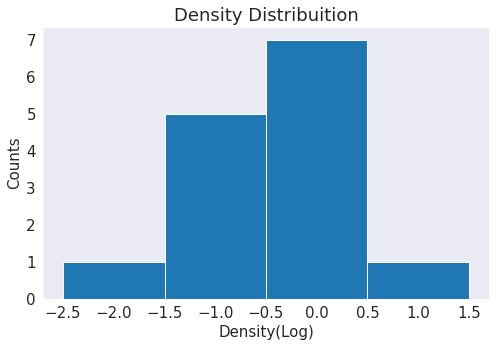

In [ ]:
df_d = pd.read_csv('data/SB0_SFB_densities.csv').rename(columns = {'z_1':'z'})
plt.figure(figsize=(8,5))

data = df_d.density
bins = np.arange(-2.5,2,1)

plt.hist(data,bins)
plt.xlabel('Density(Log)')
plt.ylabel('Counts')
plt.title('Density Distribuition');

In [ ]:
with open('data/kurk_manga_bar_s0.ascii',mode='r') as f:
  lines = f.readlines()
  f.close()

dat = []
for line in lines[1:]:
  dat.append([float(item) if i not in [0,1,2] else item for i,item in enumerate(line.split())])

df_kurk = pd.DataFrame(dat, columns = lines[0].split()[1:])

In [ ]:
df_kurk

,SDSS_dr8objid,plateifu,mangaid,logMass,Bar/Ti,B/Ti,u-r-disc,u-r-bar,u-r-bulge,g-i-disc,...,g-i-bulge,n-disc,re-disc,ba-disc,n-bar,re-bar,ba-bar,n-bulge,re-bulge,ba-bulge
0,1237651272963326121,10001-1902,1-48201,10.44,0.13,0.31,2.65,2.27,2.65,1.21,...,1.19,1.0,20.70,0.80,0.62,9.10,0.33,0.95,2.37,0.87
1,1237651273500327989,10001-6103,1-48208,10.86,0.17,0.20,2.25,2.82,2.70,1.15,...,1.25,1.0,27.88,0.89,0.34,10.18,0.56,1.03,1.85,0.95
2,1237657595686355278,10215-3704,1-153589,10.85,0.16,0.18,2.49,2.98,2.04,1.14,...,1.21,1.0,14.50,0.84,0.45,5.76,0.42,0.89,1.62,0.88
3,1237664874576937381,10216-6101,1-412105,10.76,0.21,0.12,2.28,2.15,2.19,1.05,...,1.04,1.0,22.00,0.75,0.56,8.45,0.53,0.91,1.39,0.83
4,1237664835384771068,10217-6103,1-412058,10.42,0.27,0.13,2.14,1.85,1.28,0.96,...,0.91,1.0,13.39,0.92,0.30,9.62,0.32,0.12,0.82,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,1237667323797962933,9876-3704,1-457163,10.14,0.10,0.31,2.31,2.33,2.47,1.02,...,1.12,1.0,18.65,0.86,0.10,14.34,0.25,2.42,6.02,0.53
121,1237667444585201702,9877-12701,1-623330,10.30,0.06,0.56,2.28,2.47,2.46,1.02,...,1.16,1.0,24.18,0.85,0.11,11.72,0.29,3.34,5.05,0.80
122,1237665531171373201,9881-3703,1-458301,10.43,0.14,0.16,2.17,2.75,2.61,1.04,...,1.38,1.0,15.41,0.69,0.41,6.43,0.40,1.05,1.47,0.80
123,1237655474509382051,9883-3703,1-176928,10.58,0.17,0.31,3.04,2.29,2.65,1.24,...,1.24,1.0,22.47,0.85,0.51,13.45,0.28,1.08,2.83,0.74


In [ ]:
df_out = pd.merge(df,df_kurk,on = 'mangaid')
df_out

,plateifu_x,mangaid,objra,objdec,VI_morph,DR,SDSS_dr8objid,plateifu_y,logMass,Bar/Ti,...,g-i-bulge,n-disc,re-disc,ba-disc,n-bar,re-bar,ba-bar,n-bulge,re-bulge,ba-bulge
0,10001-1902,1-48201,134.193923,56.786747,S0,16,1237651272963326121,10001-1902,10.44,0.13,...,1.19,1.0,20.70,0.80,0.62,9.10,0.33,0.95,2.37,0.87
1,10001-6103,1-48208,134.008123,57.390964,S0,16,1237651273500327989,10001-6103,10.86,0.17,...,1.25,1.0,27.88,0.89,0.34,10.18,0.56,1.03,1.85,0.95
2,7957-1901,1-634477,255.895284,36.401536,S0,16,1237655504034201663,7957-1901,9.96,0.09,...,1.22,1.0,25.55,0.40,0.20,7.64,0.48,2.25,4.22,0.81
3,7964-6103,1-179135,315.474939,-0.304685,S0,16,1237663457238844107,7964-6103,10.41,0.36,...,0.00,1.0,14.09,0.90,2.07,3.50,0.53,0.00,0.00,0.00
4,8133-3701,1-377686,112.079253,43.302118,S0,16,1237663917335183755,8133-3701,10.25,0.21,...,1.76,1.0,9.49,0.72,0.44,5.91,0.36,0.30,0.95,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,9504-3704,1-164244,123.371658,29.037198,S0,17,1237658191609528484,9504-3704,10.49,0.34,...,0.96,1.0,15.31,0.90,0.34,6.82,0.51,0.35,1.20,0.94
115,9862-12701,1-455941,193.192823,27.906805,S0,17,1237667444048003160,9862-12701,9.81,0.20,...,1.14,1.0,16.49,0.84,0.36,10.26,0.34,1.22,2.49,0.82
116,9874-6101,1-456952,195.078300,27.937101,S0,17,1237667444048723991,9874-6101,9.70,0.29,...,0.00,1.0,16.51,0.95,1.62,7.61,0.27,0.00,0.00,0.00
117,9877-12701,1-623330,194.146629,28.275454,S0,17,1237667444585201702,9877-12701,10.30,0.06,...,1.16,1.0,24.18,0.85,0.11,11.72,0.29,3.34,5.05,0.80


## **xGASS**

### **Representative Sample**


In [10]:
def demo_con_style(ax, connectionstyle):
    x1, y1 = -2.5, -2.0
    x2, y2 =  -2.0, -2.5

    ax.plot([x1, x2], [y1, y2], ".",label='_nolegend_')
    ax.annotate("",
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->", color="black",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle=connectionstyle,
                                ),
                )
    ax.text(-2.25,-2.25,s='1 dex', rotation = -45, fontsize = 20)

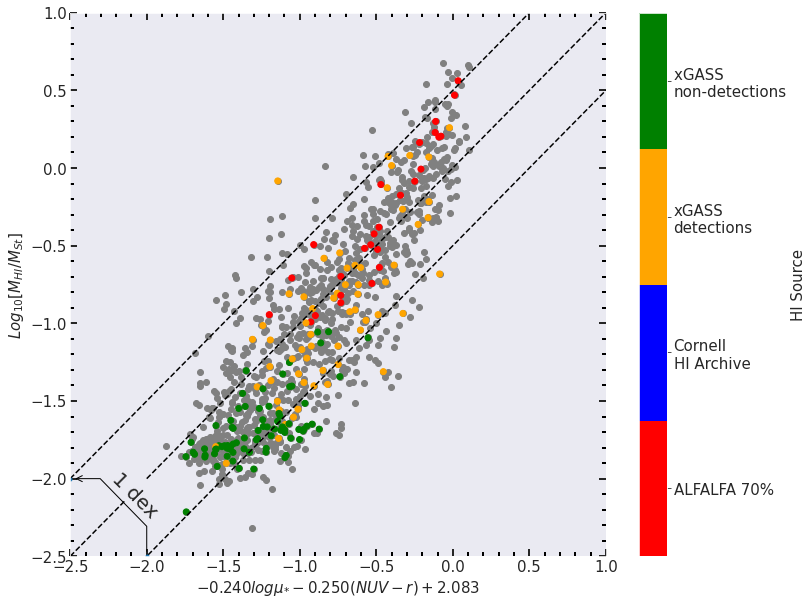

In [11]:
tab_rep = Table.read('data/xGASS_GSWLC.fits')


fig, ax  = plt.subplots(figsize = (12,10))

M        = pow(10,tab_rep['lgMstar'])
R50z     = tab_rep['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = tab_rep['lgGF'] 
NUV_r    = tab_rep['NUVr']
tab_rep['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = tab_rep['lgMH_Mst_pred']
y = lgMH_Mst

ax.scatter(x,y,color = 'grey', label = 'Total')


tab_rep_M = Table.read('data/xGASS_MaNGA_GSWLC.fits')

M        = pow(10,tab_rep_M['lgMstar'])
R50z     = tab_rep_M['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = tab_rep_M['lgGF'] 
NUV_r    = tab_rep_M['NUVr']
tab_rep_M['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = tab_rep_M['lgMH_Mst_pred']
y = lgMH_Mst

cmap = colors.ListedColormap(['red','blue','orange','green'])

img = ax.scatter(x,y,c=tab_rep_M['HIsrc'] , cmap = cmap , vmin = 0.5, vmax = 4.5,
                 label = 'MaNGA')

cb = plt.colorbar(img, label = r"HI Source")
cb.set_ticks([1,2,3,4])
cb.ax.set_yticklabels(['ALFALFA 70%', 'Cornell\nHI Archive','xGASS\ndetections','xGASS \nnon-detections'])
x= np.linspace(-2.5,1)

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
fig.savefig('xGASS.pdf')
#fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

### **HI-Deficient**

In [12]:
tab_rep['HI_Def'] = tab_rep['lgMH_Mst_pred'] - tab_rep['lgGF']
tab_HI_def = tab_rep[tab_rep['HI_Def'] >=0.5]

tab_rep_M['HI_Def'] = tab_rep_M['lgMH_Mst_pred'] - tab_rep_M['lgGF']
tab_HI_def_M = tab_rep_M[tab_rep_M['HI_Def'] >=0.5]

#### **Star-Forming**

In [13]:
ids = ['1-456339','1-456772','1-457009', '1-116725','1-53952', '1-335441', 
       '1-117014', '1-389509', '1-298482', '1-42704', '1-298715', '1-42718']
ids_ = ['1-623756', '1-591260', '1-457175', '1-456698', '1-457185', '1-404358',
        '1-456399', '1-335271','1-384400', '1-82382', '1-115158', '1-115334',
        '1-115435', '1-117543', '1-83393', '1-115377', '1-42274', '1-230042',
        '1-42184', '1-78688', '1-120103', '1-119212']

In [14]:
len(ids), len(ids_)

(12, 22)

In [15]:
tab = Table.read('data/xGASS_MaNGA_GSWLC.fits')
p = []
for i in tab['plateifu']:
  p.append(i.split()[0])

m = []
for i in tab['mangaid']:
  m.append(i.split()[0])

df = tab[['plateifu','mangaid','RA_1', 'Dec_1', 'zSDSS','Dlum','lgMstar', 
                          'petrR50_r','petrR90_r', 'petrR50_z', 'lgmust',
                          'lgM', 'lgssfr', 'NUVr', 
                          'lgSFR_tot_median', 'SFR_best', 
                          'SFRerr_best', 'SFRcase_best', 
                          'zHI','W50cor', 'lgMHI', 'lgGF',
                          'weight', 'Ngal_B', 'logMh_Mst_B',
                          'lvir_ratB']].to_pandas()
df['plateifu'] = p
df['mangaid']  = m

In [16]:
df_SF = df[0:0]
for i in ids:
  df_SF = df_SF.append(df[df['mangaid']==i])

In [17]:
df_SF

,plateifu,mangaid,RA_1,Dec_1,zSDSS,Dlum,lgMstar,petrR50_r,petrR90_r,petrR50_z,...,SFRerr_best,SFRcase_best,zHI,W50cor,lgMHI,lgGF,weight,Ngal_B,logMh_Mst_B,lvir_ratB
33,11014-12705,1-456339,194.476520,27.490639,0.016611,72.099998,9.807007,7.63,14.52,7.19,...,0.000000,9,0.000000,0.0,8.126,-1.681,1.790,3,0.0000,-99.000000
42,8934-3701,1-456772,194.025420,27.678109,0.016483,71.500000,9.118738,3.23,7.81,3.32,...,0.136318,1,0.016325,110.0,8.437,-0.682,2.294,1,0.0000,-99.000000
54,8934-6102,1-457009,196.046870,27.490445,0.017770,77.099998,9.926116,5.27,13.42,4.89,...,0.000000,9,0.000000,0.0,8.277,-1.649,1.308,1,0.0000,-99.000000
75,12083-12705,1-116725,344.361230,13.001654,0.025680,112.099998,10.556000,7.08,16.92,6.24,...,0.178723,1,0.025744,240.0,9.003,-1.553,0.634,12,13.1901,-0.459056
122,9512-9102,1-53952,140.138670,0.721037,0.017200,74.599998,9.018043,6.69,11.75,5.32,...,0.040218,2,0.017172,56.0,8.082,-0.936,2.518,8,12.5783,-0.097484
142,11967-1901,1-335441,231.947610,9.624913,0.031190,136.800003,10.569000,3.07,9.55,2.85,...,0.190559,1,0.031252,332.0,8.965,-1.604,0.634,1,11.9444,-3.950069
21,12085-6103,1-117014,345.929430,13.926541,0.027060,118.300003,10.405000,3.88,10.23,3.56,...,0.218348,1,0.027092,453.0,9.012,-1.393,0.712,1,11.9171,-3.898737
126,8150-6104,1-389509,147.539000,33.569333,0.027030,118.199997,10.611000,5.56,15.62,4.82,...,0.178555,1,0.000000,0.0,8.872,-1.739,0.712,1,12.1383,-4.429047
50,9495-6101,1-298482,122.550740,22.772292,0.015594,67.599998,9.366620,4.73,10.14,4.62,...,0.000000,9,0.015624,92.0,8.102,-1.265,2.470,2,0.0000,-99.000000
4,9195-6102,1-42704,27.653678,13.110230,0.016488,71.500000,9.249792,4.78,12.77,5.14,...,0.000000,9,0.016531,62.0,7.939,-1.311,2.775,31,13.0449,-0.298188


Text(0.5, 0.92, 'HI Deficient Galaxies in MaNGA DR17')

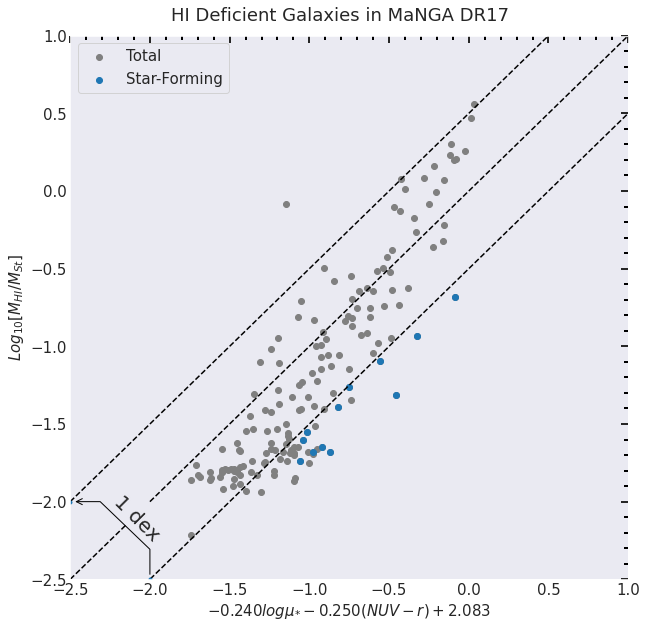

In [18]:
fig, ax  = plt.subplots(figsize = (10,10))

M        = pow(10,df['lgMstar'])
R50z     = df['petrR50_z']
u_       = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = df['lgGF'] 
NUV_r    = df['NUVr']
df['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = df['lgMH_Mst_pred']
y = lgMH_Mst

ax.scatter(x,y,color = 'grey', label = 'Total')

M        = pow(10,df_SF['lgMstar'])
R50z     = df_SF['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = df_SF['lgGF'] 
NUV_r    = df_SF['NUVr']

df_SF['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = df_SF['lgMH_Mst_pred']
y = lgMH_Mst

z = []

img = ax.scatter(x,y,label = 'Star-Forming')

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend()
fig.suptitle('HI Deficient Galaxies in MaNGA DR17', y = 0.92)

In [19]:
df['HI_Def'] = df['lgMH_Mst_pred'] - df['lgGF']
df_HI_def    = df[df['HI_Def']>=0.5]

df_SF = df[0:0]
for i in ids:
  df_SF = df_SF.append(df[df['mangaid']==i])

In [20]:
df_SF.keys()

Index(['plateifu', 'mangaid', 'RA_1', 'Dec_1', 'zSDSS', 'Dlum', 'lgMstar',
       'petrR50_r', 'petrR90_r', 'petrR50_z', 'lgmust', 'lgM', 'lgssfr',
       'NUVr', 'lgSFR_tot_median', 'SFR_best', 'SFRerr_best', 'SFRcase_best',
       'zHI', 'W50cor', 'lgMHI', 'lgGF', 'weight', 'Ngal_B', 'logMh_Mst_B',
       'lvir_ratB', 'lgMH_Mst_pred', 'HI_Def'],
      dtype='object')

In [21]:
df_SF[['plateifu','mangaid', 'RA_1','Dec_1','zSDSS','NUVr', 'lgMstar','lgMHI','HI_Def']]

,plateifu,mangaid,RA_1,Dec_1,zSDSS,NUVr,lgMstar,lgMHI,HI_Def
33,11014-12705,1-456339,194.476520,27.490639,0.016611,4.82,9.807007,8.126,0.808111
42,8934-3701,1-456772,194.025420,27.678109,0.016483,1.69,9.118738,8.437,0.595712
54,8934-6102,1-457009,196.046870,27.490445,0.017770,4.57,9.926116,8.277,0.729663
75,12083-12705,1-116725,344.361230,13.001654,0.025680,4.54,10.556000,9.003,0.540812
122,9512-9102,1-53952,140.138670,0.721037,0.017200,3.14,9.018043,8.082,0.609671
142,11967-1901,1-335441,231.947610,9.624913,0.031190,3.99,10.569000,8.965,0.562829
21,12085-6103,1-117014,345.929430,13.926541,0.027060,3.44,10.405000,9.012,0.575059
126,8150-6104,1-389509,147.539000,33.569333,0.027030,4.46,10.611000,8.872,0.679786
50,9495-6101,1-298482,122.550740,22.772292,0.015594,4.38,9.366620,8.102,0.515602
4,9195-6102,1-42704,27.653678,13.110230,0.016488,3.40,9.249792,7.939,0.856875


#### **Quenched**

In [22]:
df_noSF = df_HI_def[0:0]

for i  in df_HI_def['mangaid'].values:
  if i not in ids:
    df_noSF = df_noSF.append(df_HI_def[df_HI_def['mangaid']==i])

In [23]:
df_noSF[['plateifu','mangaid', 'RA_1','Dec_1']]

,plateifu,mangaid,RA_1,Dec_1
0,8087-9101,1-119212,356.692320,16.043083
11,9863-6104,1-623756,195.288470,27.818327
16,9509-12703,1-230042,124.105670,25.991356
30,9863-12704,1-591260,195.068820,27.967522
31,10517-3703,1-78688,150.264040,4.619273
55,7978-6104,1-115377,333.590720,13.953097
61,9874-9102,1-404358,194.612210,29.612479
62,9880-12702,1-457185,195.646580,27.439437
64,12506-6102,1-82382,218.579250,3.664377
78,11968-12704,1-335271,229.764110,8.138726


Text(8.6, -12.4, 'Quenched')

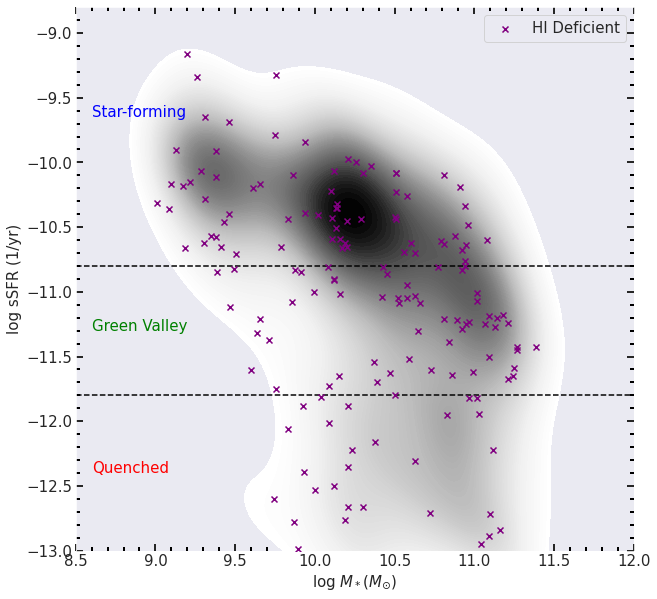

In [24]:
fig, ax  = plt.subplots()

x = tab_HI_def['lgM']
y = tab_HI_def['lgssfr']

ax.scatter(x,y, marker = 'x', zorder = 101, color = 'purple')


x = tab_rep['lgM'].value
y = tab_rep['lgssfr'].value

x = np.where(x<7,np.nan, x)

x = x.astype('float')
y = y.astype('float')
sb.kdeplot(x=x,y=y, fill = True, levels = 100, ax = ax, cmap = 'Greys')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

ax.set_ylim(-13,-8.8)
ax.set_xlim(8.5,12)
ax.plot([8.5,13], [-10.8,-10.8], '--', color = 'black',label = '_nolegend_')

ax.plot([8.5,13], [-11.8,-11.8], '--', color = 'black',label = '_nolegend_')
ax.set_xlabel(r'log $M_*(M_{\odot})$')
ax.set_ylabel('log sSFR (1/yr)')
ax.legend(['HI Deficient'])

ax.annotate('Star-forming',(8.6,-9.65), color = 'blue')
ax.annotate('Green Valley',(8.6,-11.3), color = 'green')
ax.annotate('Quenched',(8.6,-12.4), color = 'red')

Text(8.6, -12.4, 'Quenched')

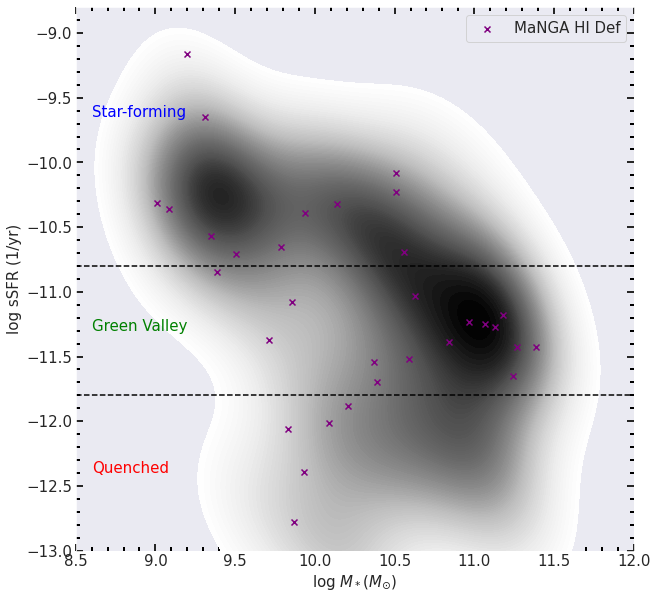

In [25]:
fig, ax  = plt.subplots()

x = tab_HI_def_M['lgM']
y = tab_HI_def_M['lgssfr']

ax.scatter(x,y, marker = 'x', zorder = 101, color = 'purple')

x = tab_rep_M['lgM'].value
y = tab_rep_M['lgssfr'].value

x = x.astype('float')
y = y.astype('float')
sb.kdeplot(x=x,y=y, fill = True, levels = 100, ax = ax, cmap = 'Greys')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

ax.set_ylim(-13,-8.8)
ax.set_xlim(8.5,12)
ax.plot([8.5,13], [-10.8,-10.8], '--', color = 'black',label = '_nolegend_')

ax.plot([8.5,13], [-11.8,-11.8], '--', color = 'black',label = '_nolegend_')
ax.set_xlabel(r'log $M_*(M_{\odot})$')
ax.set_ylabel('log sSFR (1/yr)')
ax.legend(['MaNGA HI Def'])
ax.annotate('Star-forming',(8.6,-9.65), color = 'blue')
ax.annotate('Green Valley',(8.6,-11.3), color = 'green')
ax.annotate('Quenched',(8.6,-12.4), color = 'red')

Text(8.6, -12.4, 'Quenched')

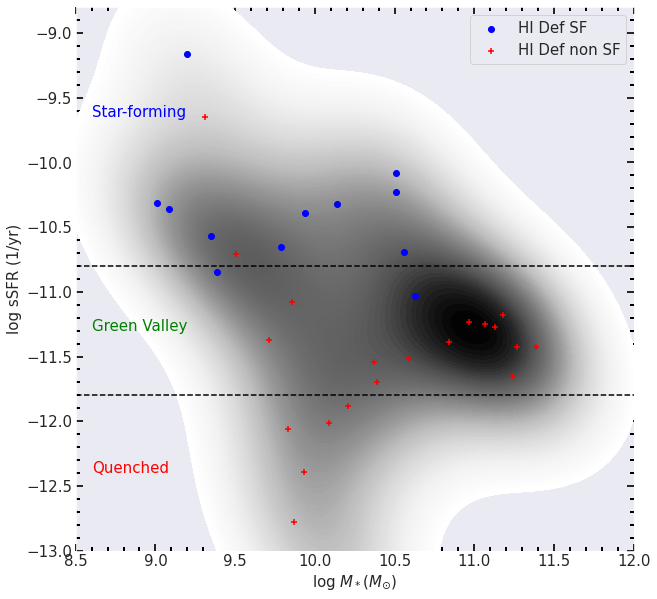

In [26]:
fig, ax  = plt.subplots()

x = df_SF['lgM']
y = df_SF['lgssfr']
ax.scatter(x,y, marker = 'o', zorder = 101, color = 'blue')

x = df_noSF['lgM']
y = df_noSF['lgssfr']
ax.scatter(x,y, marker = '+', zorder = 101, color = 'red')

x = tab_HI_def_M['lgM'].value
y = tab_HI_def_M['lgssfr']

x = x.astype('float')
y = y.astype('float')
sb.kdeplot(x=x,y=y, fill = True, levels = 100, ax = ax, cmap = 'Greys')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

ax.set_ylim(-13,-8.8)
ax.set_xlim(8.5,12)
ax.plot([8.5,13], [-10.8,-10.8], '--', color = 'black',label = '_nolegend_')

ax.plot([8.5,13], [-11.8,-11.8], '--', color = 'black',label = '_nolegend_')
ax.set_xlabel(r'log $M_*(M_{\odot})$')
ax.set_ylabel('log sSFR (1/yr)')
ax.legend(['HI Def SF','HI Def non SF'])
ax.annotate('Star-forming',(8.6,-9.65), color = 'blue')
ax.annotate('Green Valley',(8.6,-11.3), color = 'green')
ax.annotate('Quenched',(8.6,-12.4), color = 'red')

In [27]:
t_dep_SF = (df_SF['lgMHI'].values- (df_SF['lgssfr'] + df_SF['lgM']))

In [28]:
t_dep_noSF = (df_noSF['lgMHI'].values- (df_noSF['lgssfr'] + df_noSF['lgM']))

In [29]:
t_dep_tot = (tab_rep['lgMHI'].value- (tab_rep['lgssfr'] + tab_rep['lgM']))

Text(0, 0.5, 'Normalized Frequency')

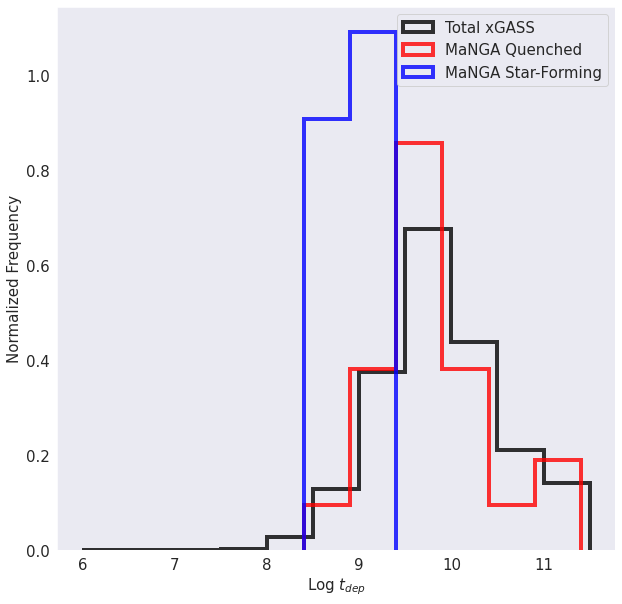

In [30]:
step = 0.5

bins = np.arange(6,12, step)
plt.hist(t_dep_tot, bins = bins, histtype = 'step', density = True, 
         linewidth = 4, color = 'black', alpha = 0.8)

bins = np.arange(t_dep_noSF.min(),t_dep_noSF.max(),step)
plt.hist(t_dep_noSF, bins = bins,  histtype = 'step', density = True, 
         linewidth = 4, color = 'red', alpha = 0.8)

bins = np.arange(t_dep_SF.min(),t_dep_SF.max(), step)
plt.hist(t_dep_SF, bins = bins,  histtype = 'step', density = True, 
         linewidth = 4, color = 'blue', alpha = 0.8)

plt.legend(['Total xGASS', 'MaNGA Quenched', 'MaNGA Star-Forming'])
plt.xlabel(r'Log $t_{dep}$')
plt.ylabel('Normalized Frequency')

In [31]:
146.5 - 87.5

59.0

In [32]:
!wget https://data.sdss.org/sas/dr17/manga/photo/pymorph/1.1.1/manga-pymorph-DR17.fits

--2022-10-08 10:31:06--  https://data.sdss.org/sas/dr17/manga/photo/pymorph/1.1.1/manga-pymorph-DR17.fits
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13878720 (13M) [application/octet-stream]
Saving to: ‘manga-pymorph-DR17.fits’

manga-pymorph-DR17. 100%[===================>]  13.24M   449KB/s    in 31s     

2022-10-08 10:31:38 (443 KB/s) - ‘manga-pymorph-DR17.fits’ saved [13878720/13878720]



In [33]:
hdul = fits.open('manga-pymorph-DR17.fits')
tab_pym_g    = Table.read(hdul[1])
tab_pym_r    = Table.read(hdul[2])
tab_pym_i    = Table.read(hdul[3])

In [34]:
tab_pym_g.rename_column('MANGA_ID', 'mangaid')
tab_pym_r.rename_column('MANGA_ID', 'mangaid')
tab_pym_i.rename_column('MANGA_ID', 'mangaid')

In [35]:
m = []
for i in tab_HI_def_M['mangaid']:
  m.append(i.split()[0])

tab_HI_def_M['mangaid'] = m

In [36]:
tab_comb_g = join(tab_HI_def_M, tab_pym_g, keys = ['mangaid'] )
tab_comb_r = join(tab_HI_def_M, tab_pym_r, keys = ['mangaid'] )
tab_comb_i = join(tab_HI_def_M, tab_pym_i, keys = ['mangaid'] )

In [37]:
cl = []
for i in tab_comb_g['mangaid']:
  if i.split()[0] in ids:
    cl.append(1)
  else:
    cl.append(0)

In [38]:
tab_comb_g['SF_class'] = cl
tab_comb_r['SF_class'] = cl
tab_comb_i['SF_class'] = cl

In [39]:
for i in ids_:
  row = tab_comb_g[tab_comb_g['mangaid']==i]
  if row['FLAG_FIT'] == 2 or row['FLAG_FIT'] == 0:

    R_e   = row ['A_HL_SE_BULGE'].value
    mu_e  = row['M_SE_BULGE'].value + 2.5*np.log10(2*np.pi*R_e**2) 
    mu_e += 2.5*np.log10(row['BA_SE_BULGE']) -  10*np.log10(1 + row['Z'])
    n_e   = row['N_SE_BULGE'].value

    R_e   = np.round(R_e,2)
    mu_e   = np.round(mu_e,2)
    n_e   = np.round(n_e,2)

    R_d   = row['A_HL_SE_DISK'].value/( 1.9992*row['N_SE_DISK'].value - 0.3271)
    mu_d  = row['M_SE_DISK'].value + 2.5*np.log10(2*np.pi*R_d**2) 
    mu_d += 2.5*np.log10(row['BA_SE_DISK']) -  10*np.log10(1 + row['Z'])
    n_d   = row['N_SE_DISK'].value

    R_d   = np.round(R_d,2)
    mu_d   = np.round(mu_d,2)
    n_d   = np.round(n_d,2)

    if R_e>R_d:
      temp = R_e
      R_e = R_d
      R_d = temp

      temp = mu_e
      mu_e = mu_d
      mu_d = temp

      temp = n_e
      n_e = n_d
      n_d = temp
  
  else : 
    R_e   = '-'
    mu_e  = '-'
    n_e   = '-'

    R_d   = row['A_HL_S'].value/( 1.9992*row['N_S'].value - 0.3271)
    mu_d  = row['M_S'].value + 2.5*np.log10(2*np.pi*R_d**2) 
    mu_d += 2.5*np.log10(row['BA_S']) -  10*np.log10(1 + row['Z'])
    n_d   = row['N_S'].value

    R_d   = np.round(R_d,2)
    mu_d   = np.round(mu_d,2)
    n_d   = np.round(n_d,2)

  print(f"{row['mangaid'].value[0]} ",   end = ' & ')
  print(f'{mu_e[0]} & {R_e[0]} & {n_e[0]} & {mu_d[0]} & {R_d[0]} & {n_d[0]} &', end = ' ')

  row = tab_comb_r[tab_comb_r['mangaid']==i]
  if row['FLAG_FIT'] == 2 or row['FLAG_FIT'] == 0:

    R_e   = row ['A_HL_SE_BULGE'].value
    mu_e  = row['M_SE_BULGE'].value + 2.5*np.log10(2*np.pi*R_e**2) 
    mu_e += 2.5*np.log10(row['BA_SE_BULGE']) -  10*np.log10(1 + row['Z'])
    n_e   = row['N_SE_BULGE'].value

    R_e   = np.round(R_e,2)
    mu_e   = np.round(mu_e,2)
    n_e   = np.round(n_e,2)

    R_d   = row['A_HL_SE_DISK'].value/( 1.9992*row['N_SE_DISK'].value - 0.3271)
    mu_d  = row['M_SE_DISK'].value + 2.5*np.log10(2*np.pi*R_d**2) 
    mu_d += 2.5*np.log10(row['BA_SE_DISK']) -  10*np.log10(1 + row['Z'])
    n_d   = row['N_SE_DISK'].value

    R_d   = np.round(R_d,2)
    mu_d   = np.round(mu_d,2)
    n_d   = np.round(n_d,2)

    if R_e>R_d:
      temp = R_e
      R_e = R_d
      R_d = temp

      temp = mu_e
      mu_e = mu_d
      mu_d = temp

      temp = n_e
      n_e = n_d
      n_d = temp
  
  else : 
    R_e   = '-'
    mu_e  = '-'
    n_e   = '-'

    R_d   = row['A_HL_S'].value/( 1.9992*row['N_S'].value - 0.3271)
    mu_d  = row['M_S'].value + 2.5*np.log10(2*np.pi*R_d**2) 
    mu_d += 2.5*np.log10(row['BA_S']) -  10*np.log10(1 + row['Z'])
    n_d   = row['N_S'].value

    R_d   = np.round(R_d,2)
    mu_d   = np.round(mu_d,2)
    n_d   = np.round(n_d,2)

  print(f'{mu_e[0]} & {R_e[0]} & {n_e[0]} & {mu_d[0]} & {R_d[0]} & {n_d[0]} &', end = ' ')

  row = tab_comb_i[tab_comb_i['mangaid']==i]
  if row['FLAG_FIT'] == 2 or row['FLAG_FIT'] == 0:

    R_e   = row ['A_HL_SE_BULGE'].value
    mu_e  = row['M_SE_BULGE'].value + 2.5*np.log10(2*np.pi*R_e**2) 
    mu_e += 2.5*np.log10(row['BA_SE_BULGE']) -  10*np.log10(1 + row['Z'])
    n_e   = row['N_SE_BULGE'].value

    R_e   = np.round(R_e,2)
    mu_e   = np.round(mu_e,2)
    n_e   = np.round(n_e,2)

    R_d   = row['A_HL_SE_DISK'].value/( 1.9992*row['N_SE_DISK'].value - 0.3271)
    mu_d  = row['M_SE_DISK'].value + 2.5*np.log10(2*np.pi*R_d**2) 
    mu_d += 2.5*np.log10(row['BA_SE_DISK']) -  10*np.log10(1 + row['Z'])
    n_d   = row['N_SE_DISK'].value

    R_d   = np.round(R_d,2)
    mu_d   = np.round(mu_d,2)
    n_d   = np.round(n_d,2)

    if R_e>R_d:
      temp = R_e
      R_e = R_d
      R_d = temp

      temp = mu_e
      mu_e = mu_d
      mu_d = temp

      temp = n_e
      n_e = n_d
      n_d = temp
  
  else : 
    R_e   = '-'
    mu_e  = '-'
    n_e   = '-'

    R_d   = row['A_HL_S'].value/( 1.9992*row['N_S'].value - 0.3271)
    mu_d  = row['M_S'].value + 2.5*np.log10(2*np.pi*R_d**2) 
    mu_d += 2.5*np.log10(row['BA_S']) -  10*np.log10(1 + row['Z'])
    n_d   = row['N_S'].value

    R_d   = np.round(R_d,2)
    mu_d   = np.round(mu_d,2)
    n_d   = np.round(n_d,2)
  print(f'{mu_e[0]} & {R_e[0]} & {n_e[0]} & {mu_d[0]} & {R_d[0]} & {n_d[0]} \\\\')

1-623756  & - & - & - & 16.96 & 1.16 & 7.12 & - & - & - & 16.01 & 1.04 & 7.12 & - & - & - & 15.8 & 1.18 & 8.0 \\
1-591260  & 18.49 & 0.78 & 1.32 & 20.04 & 4.32 & 1.0 & 17.41 & 0.74 & 1.28 & 19.3 & 4.36 & 1.0 & 16.98 & 0.73 & 1.53 & 18.93 & 4.34 & 1.0 \\
1-457175  & 20.63 & 2.6 & 1.33 & 21.72 & 5.95 & 1.0 & 19.5 & 1.99 & 1.45 & 20.71 & 5.38 & 1.0 & 19.0 & 1.83 & 1.53 & 20.3 & 5.32 & 1.0 \\
1-456698  & 17.86 & 0.34 & 1.0 & 20.54 & 3.65 & 1.0 & 18.14 & 0.8 & 1.85 & 18.98 & 2.4 & 1.0 & 19.08 & 1.91 & 1.95 & 19.0 & 2.58 & 1.0 \\
1-457185  & - & - & - & 18.77 & 2.01 & 3.43 & - & - & - & 18.33 & 2.13 & 3.27 & - & - & - & 18.02 & 2.15 & 3.39 \\
1-404358  & 20.61 & 2.54 & 3.71 & 19.62 & 3.21 & 1.0 & 19.59 & 2.03 & 4.1 & 18.91 & 3.21 & 1.0 & 19.43 & 2.58 & 6.32 & 18.58 & 3.18 & 1.0 \\
1-456399  & 20.41 & 2.56 & 0.73 & 20.33 & 3.1 & 1.0 & 19.85 & 2.63 & 0.75 & 19.89 & 3.37 & 1.0 & 19.44 & 2.55 & 0.75 & 19.41 & 3.15 & 1.0 \\
1-335271  & - & - & - & 17.49 & 2.23 & 4.21 & - & - & - & 16.59 & 2.07 & 

### **Density**

Text(0.5, 0.92, 'HI Scaling relation using NUV-r')

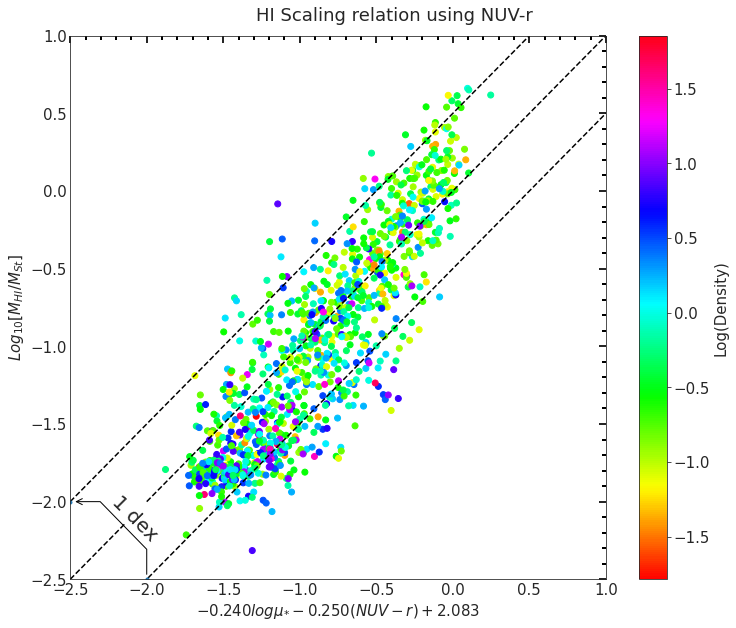

In [ ]:
tab_rep = Table.read('data/xGASS_Baldry.fits')

fig, ax  = plt.subplots(figsize = (12,10))

M        = pow(10,tab_rep['lgMstar'])
R50z     = tab_rep['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = tab_rep['lgGF'] 
NUV_r    = tab_rep['NUVr']
tab_rep['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x_ = tab_rep['lgMH_Mst_pred'].value
y_ = tab_rep['lgGF'] 

img = ax.scatter(x_,y_,c= tab_rep['density'], cmap = 'hsv')
plt.colorbar(img, label = 'Log(Density)')
x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

Text(0.5, 0.92, 'HI Scaling relation using NUV-r')

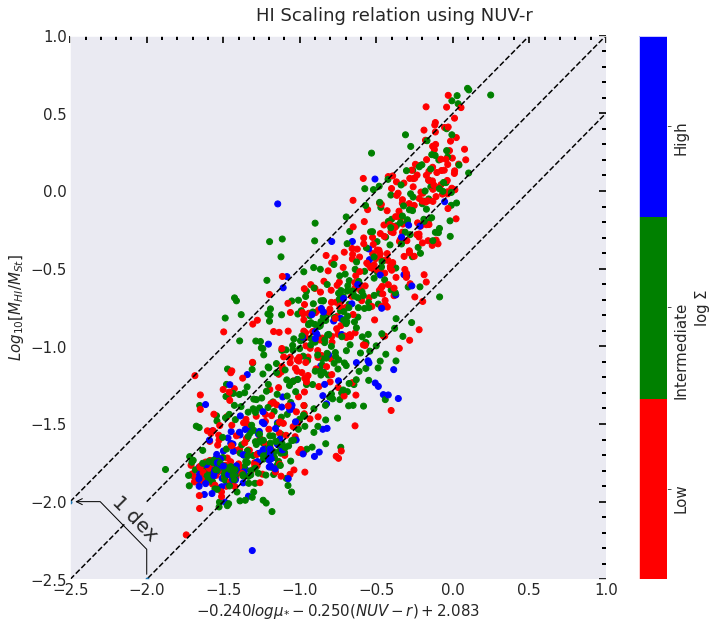

In [ ]:
fig, ax  = plt.subplots(figsize = (12,10))
z = []

for i in tab_rep['density']:
  if i<-0.5:
    z.append(-1)
  elif i>=-0.5 and i<=0.5:
    z.append(0)
  elif i>0.5:
    z.append(1)
z = np.array(z)
cmap = colors.ListedColormap(['red', 'green', 'blue'])
img = ax.scatter(x_,y_,c=z , cmap = cmap, vmin = -1.5,vmax =1.5 
                 , label = '_nolegend_')

cb = plt.colorbar(img, label = r"log $\Sigma$")
cb.set_ticks([-1,0,1])
cb.ax.set_yticklabels(['Low','Intermediate','High'], rotation = 90)
x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black', label = '_nolegend_')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black', label = '_nolegend_')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black', label = '_nolegend_')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

In [ ]:
tab_rep = Table.read('data/xGASS_MaNGA_Baldry.fits')['plateifu','mangaid','RA_1', 
                                         'DEC_1', 'zSDSS', 'nsa_sersic_absmag',
                                          'Dlum','lgMstar', 'expAB_r', 'model_r',
                                          'merr_r', 'ext_r', 'petrR50_r',
                                          'petrR90_r', 'petrR50_z', 'lgmust',
                                          'CINDX', 'INCL', 'NUVr', 
                                          'lgSFR_tot_median', 'SFR_best', 
                                          'SFRerr_best', 'SFRcase_best', 
                                          'zHI','W50cor', 'lgMHI', 'lgGF',
                                          'weight','density', 'Ngal_B', 'logMh_Mst_B',
                                          'lvir_ratB']

tab_rep['Sersic_g-i'] = tab_rep['nsa_sersic_absmag'][:,3]- tab_rep['nsa_sersic_absmag'][:,5]
tab_rep.remove_column('nsa_sersic_absmag')

p = []
for i in tab_rep['plateifu']:
  p.append(i.split()[0])

m = []
for i in tab_rep['mangaid']:
  m.append(i.split()[0])


df = tab_rep.to_pandas()
df['plateifu'] = p
df['mangaid'] = m

M        = pow(10,df['lgMstar'])
R50z     = df['petrR50_z']
u        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u)
lgMH_Mst = df['lgGF'] 
NUV_r    = df['NUVr']
df['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

df['HI_Def'] = df['lgMH_Mst_pred']-df['lgGF']
df_HI_def = df[df['HI_Def']>=0.5]

ids = ['11014-12705',
       '8934-3701',
       '8934-6102',
       '12083-12705',
       '11967-1901',
       '12085-6103',
        '8150-6104',
        '8939-3701',
        '9195-6102',
        '9495-6101',
        '8096-6101',
        '9512-9102',
        '12087-6103']


df_SF = df[0:0]
for i in ids:
  df_SF = df_SF.append(df[df['plateifu']==i])

df_noSF = df_HI_def[0:0]
for i in df_HI_def['plateifu'].values:
  if i not in ids:
    df_noSF = df_noSF.append(df_HI_def[df_HI_def['plateifu']==i])

Text(0.5, 0.92, 'HI Deficient Galaxies in MaNGA DR17')

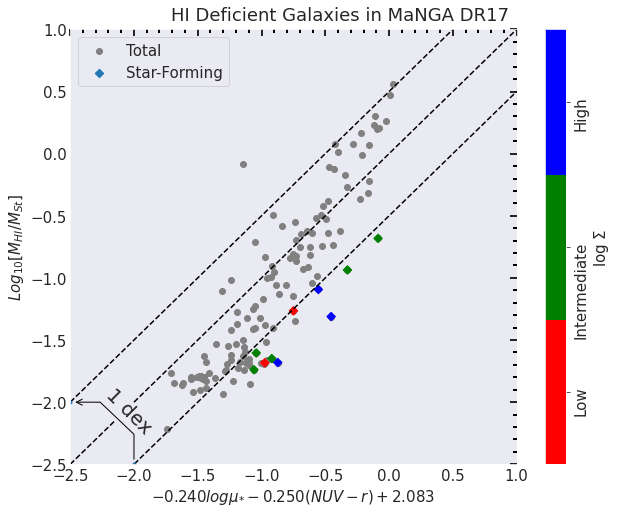

In [ ]:
fig, ax  = plt.subplots(figsize = (10,8))

x = df['lgMH_Mst_pred']
y = df['lgGF'] 

ax.scatter(x,y,color = 'grey', label = 'Total')

M        = pow(10,df_SF['lgMstar'])
R50z     = df_SF['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = df_SF['lgGF'] 
NUV_r    = df_SF['NUVr']

df_SF['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = df_SF['lgMH_Mst_pred']
y = lgMH_Mst

z = []

for i in df_SF['density']:
  if i<-0.5:
    z.append(-1)
  elif i>=-0.5 and i<=0.5:
    z.append(0)
  elif i>0.5:
    z.append(1)
z_noSF = z
cmap = colors.ListedColormap(['red', 'green', 'blue'])

img = ax.scatter(x,y, marker = 'D', c = z,cmap = cmap,
                 vmin =-1.5,vmax=1.5,label = 'Star-Forming')
cb = plt.colorbar(img,label = r"log $\Sigma$")
cb.set_ticks([-1,0,1])
cb.ax.set_yticklabels(['Low','Intermediate','High'], rotation = 90)
x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend()
fig.suptitle('HI Deficient Galaxies in MaNGA DR17', y = 0.92)

Text(0.5, 0.92, 'HI Deficient Galaxies in MaNGA DR17')

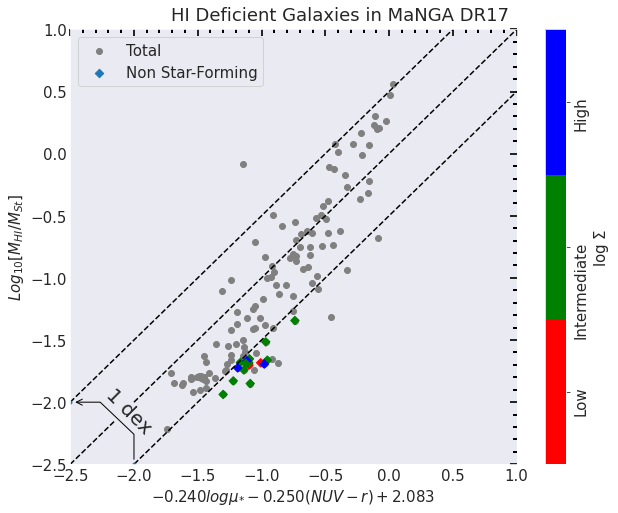

In [ ]:
fig, ax  = plt.subplots(figsize = (10,8))

x = df['lgMH_Mst_pred']
y = df['lgGF'] 

ax.scatter(x,y,color = 'grey', label = 'Total')

M        = pow(10,df_noSF['lgMstar'])
R50z     = df_noSF['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = df_noSF['lgGF'] 
NUV_r    = df_noSF['NUVr']

df_noSF['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = df_noSF['lgMH_Mst_pred']
y = lgMH_Mst

z = []

for i in df_noSF['density']:
  if i<-0.5:
    z.append(-1)
  elif i>=-0.5 and i<=0.5:
    z.append(0)
  elif i>0.5:
    z.append(1)
z_noSF = z
cmap = colors.ListedColormap(['red', 'green', 'blue'])

img = ax.scatter(x,y, marker = 'D', c = z,cmap = cmap,
                 vmin =-1.5,vmax=1.5,label = 'Non Star-Forming')
cb = plt.colorbar(img,label = r"log $\Sigma$")
cb.set_ticks([-1,0,1])
cb.ax.set_yticklabels(['Low','Intermediate','High'], rotation = 90)
x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend()
fig.suptitle('HI Deficient Galaxies in MaNGA DR17', y = 0.92)

Text(0.5, 1.0, 'Density Distribuition of xGASS')

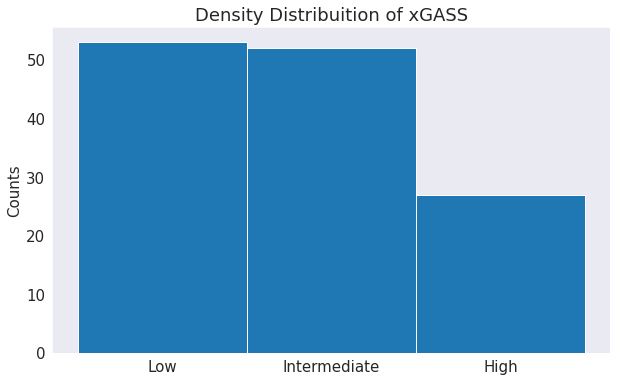

In [ ]:
bins = np.arange(-1.5,2.5,1)
plt.figure(figsize = (10,6))
plt.hist(tab_rep['density'],bins)
plt.xticks([-1,0,1 ],['Low','Intermediate','High'])
plt.ylabel('Counts')
plt.title('Density Distribuition of xGASS')

Text(0.5, 0, '$log\\Sigma$')

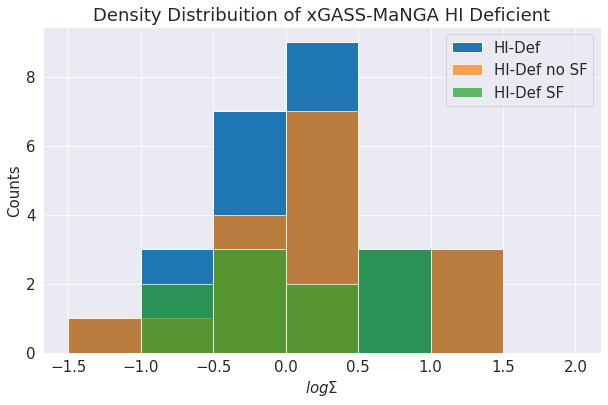

In [ ]:
bins = np.arange(-1.5,2.5,0.5)
plt.figure(figsize = (10,6))
plt.hist(df_HI_def['density'],bins)
plt.hist(df_noSF['density'],bins, alpha = 0.7)
plt.grid(True)
plt.hist(df_SF['density'],bins, alpha = 0.7)
#plt.xticks([-1,0,1],['Low','Intermediate','High'])
plt.ylabel('Counts')
plt.title('Density Distribuition of xGASS-MaNGA HI Deficient')
plt.legend(['HI-Def','HI-Def no SF','HI-Def SF']);
plt.xlabel(r'$log\Sigma$')

In [ ]:
df_SF[['plateifu','mangaid', 'zSDSS','NUVr','density', 'lgMstar','HI_Def']]

,plateifu,mangaid,zSDSS,NUVr,density,lgMstar,HI_Def
16,11014-12705,1-456339,0.016611,4.82,0.5821,9.807007,0.808111
91,8934-3701,1-456772,0.016483,1.69,0.1891,9.118738,0.595712
92,8934-6102,1-457009,0.017770,4.57,0.2874,9.926116,0.729663
34,11967-1901,1-335441,0.031190,3.99,-0.3376,10.569000,0.562829
81,8150-6104,1-389509,0.027030,4.46,-0.4114,10.611000,0.679786
94,8939-3701,1-298715,0.019782,4.41,-0.7383,10.120649,0.708209
105,9195-6102,1-42704,0.016488,3.40,0.5313,9.249792,0.856875
110,9495-6101,1-298482,0.015594,4.38,-0.5776,9.366620,0.515602
71,8096-6101,1-42718,0.017055,3.92,0.5049,9.062301,0.538736
117,9512-9102,1-53952,0.017200,3.14,-0.3234,9.018043,0.609671


In [ ]:
len(df_SF)

10

In [ ]:
temp = df_noSF[['plateifu','mangaid', 'zSDSS','NUVr', 'lgMstar','HI_Def']]

In [ ]:
p = df_noSF[0:0]
for i,row in df_noSF.iterrows():
  if row.plateifu not in temp.plateifu.values:
    p = p.append(row)

q = p[['mangaid', 'zSDSS','NUVr','lgMstar','HI_Def']]
q

,mangaid,zSDSS,NUVr,lgMstar,HI_Def
47,1-117543,0.04002,4.20,11.072,0.766789
68,1-115377,0.02611,4.93,10.781,0.585749
69,1-115158,0.02810,4.31,10.480,0.746623
70,1-115334,0.02520,4.78,10.354,0.576273
72,1-115435,0.02619,5.53,10.467,0.501046
81,1-119212,0.04162,5.16,11.309,0.537392


In [ ]:
for i, row in q.iterrows():
  for j,a in enumerate(row.values):

    if j>0:
      a = np.round(a,6)
    if j==3:
      print('- &', end =' ')

    print(a, end = ' & ')
  print('- & - & - \\\\ ')


1-117543 & 0.04002 & 4.2 & - & 11.072 & 0.766789 & - & - & - \\ 
1-115377 & 0.02611 & 4.93 & - & 10.781 & 0.585749 & - & - & - \\ 
1-115158 & 0.0281 & 4.31 & - & 10.48 & 0.746623 & - & - & - \\ 
1-115334 & 0.0252 & 4.78 & - & 10.354 & 0.576273 & - & - & - \\ 
1-115435 & 0.02619 & 5.53 & - & 10.467 & 0.501046 & - & - & - \\ 
1-119212 & 0.04162 & 5.16 & - & 11.309 & 0.537392 & - & - & - \\ 


In [ ]:
len(df_noSF)

18

In [ ]:
tab = Table.read('data/xGASS_MaNGA_HI.fits')[['PLATEIFU','MANGAID','OBJRA',
                                              'OBJDEC','zSDSS','Dlum','lgMstar',
                                              'NUVr','zHI','lgMHI','lgGF',
                                              'LOGMSTARS','LOGMHI','VHI','EV',
                                              'logMh_Mst_B','petrR50_z']]
tab.rename_column('PLATEIFU','plateifu')

p = []
for i in tab['plateifu']:
  p.append(i.split()[0])

df_MHI = tab.to_pandas()
df_MHI['plateifu'] = p

In [ ]:
fig, ax  = plt.subplots(figsize = (10,10))

M        = pow(10,tab['LOGMSTARS'])
R50z     = tab['petrR50_z']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = tab['LOGMHI']-tab['LOGMSTARS'] 
NUV_r    = tab['NUVr']
tab['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x = tab['lgMH_Mst_pred']
y = lgMH_Mst

img = ax.scatter(x,y)

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend()
fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

In [ ]:
df_xGASS_MHI = pd.merge(df_SF,df_MHI, on = 'plateifu')

In [ ]:
df_xGASS_MHI

In [ ]:
df_xGASS_MHI.keys()

In [ ]:
M        = pow(10,df_xGASS_MHI['LOGMSTARS'])
R50z     = df_xGASS_MHI['petrR50_z_x']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = df_xGASS_MHI['LOGMHI']-df_xGASS_MHI['LOGMSTARS'] 
NUV_r    = df_xGASS_MHI['NUVr_x']
df_xGASS_MHI['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x1 = df_xGASS_MHI['lgMH_Mst_pred'].values
y1 = lgMH_Mst.values

In [ ]:
lgMH_Mst

In [ ]:
plt.scatter(x1, y1)
plt.xlim()

In [ ]:
M        = pow(10,df_xGASS_MHI['lgMstar_x'])
R50z     = df_xGASS_MHI['petrR50_z_x']
u_        = M/(2*np.pi*R50z**2)
lgu      = np.log10(u_)
lgMH_Mst = df_xGASS_MHI['lgGF_x'] 
NUV_r    = df_xGASS_MHI['NUVr_x']
df_xGASS_MHI['lgMH_Mst_pred'] = -0.240*lgu -0.250*NUV_r +2.083

x2 = df_xGASS_MHI['lgMH_Mst_pred']
y2 = lgMH_Mst

In [ ]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.ylim(-2.5,1)
plt.xlim(-2.5,1)

In [ ]:
fig, ax  = plt.subplots(figsize = (10,10))

ax.scatter(x1,y1)
ax.scatter(x2,y2)

x= np.linspace(-2.5,1)
y=x
x= np.where( (x>-2.1)&(x<-2.05),np.nan,x)

ax.plot(x,y,'--', color = 'black',label='_nolegend_')

x = np.linspace(-2.5,1) 
y = x + 0.5
ax.plot(x,y,'--', color = 'black',label='_nolegend_')

x = np.linspace(-2.5,1) 
y = x - 0.5
ax.plot(x,y,'--', color = 'black',label='_nolegend_')
ax.set_xlabel(r'$-0.240log\mu_{*} -0.250(NUV-r) +2.083$')
ax.set_ylabel(r'$Log_{10}[M_{HI}/M_{St}]$')
ax.set_ylim(-2.5,1)
ax.set_xlim(-2.5,1)
demo_con_style(ax, "arc,angleA=-90,angleB=0,armA=-30,armB=30,rad=0")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend(['MaNGA-HI','xGASS-HI'])
fig.suptitle('HI Scaling relation using NUV-r', y = 0.92)

In [ ]:
df_SF

NameError: ignored

### **Coma Galaxies**

In [ ]:
tab_rep = Table.read('data/xGASS_MaNGA.fits')
tab_coma = Table.read('data/Coma CC.fit')

[WARNING]: Invalid keyword for column 6: ASCII table null option (TNULLn) is longer than the column's character width and will be truncated (got '-32768'). (VerifyWarning)
  VerifyWarning)

[WARNING]: Invalid keyword for column 9: ASCII table null option (TNULLn) is longer than the column's character width and will be truncated (got '-32768'). (VerifyWarning)
  VerifyWarning)

[WARNING]: Invalid keyword for column 12: ASCII table null option (TNULLn) is longer than the column's character width and will be truncated (got '-32768'). (VerifyWarning)
  VerifyWarning)

[WARNING]: Invalid keyword for column 15: ASCII table null option (TNULLn) is longer than the column's character width and will be truncated (got '-32768'). (VerifyWarning)
  VerifyWarning)

[WARNING]: Invalid keyword for column 18: ASCII table null option (TNULLn) is longer than the column's character width and will be truncated (got '-32768'). (VerifyWarning)
  VerifyWarning)



In [ ]:
c = SkyCoord(tab_coma['RAJ2000'], tab_coma['DEJ2000'], frame='icrs', unit=(u.hourangle, u.deg))

In [ ]:
ra = []
dec = []
for pos in c:
  ra.append(pos.ra.value)
  dec.append(pos.dec.value)

In [ ]:
df_coma = tab_coma.to_pandas()

In [ ]:
df_coma['RAJ2000'] = ra
df_coma['DEJ2000'] = dec
df_coma

,Object,RAJ2000,DEJ2000,l_S500,S500,e_S500,l_S350,S350,e_S350,l_S250,S250,e_S250,l_S160,S160,e_S160,l_S100,S100,e_S100
0,b'CCC001',192.916667,28.053056,b'<',20,0,b'<',19,0,b'<',17,0,b'<',27,0,b'<',23,0
1,b'CCC002',192.929167,27.962778,b'<',21,0,b' ',32,7,b' ',54,8,b'<',28,0,b'<',18,0
2,b'CCC003',192.970833,27.977778,b' ',23,7,b' ',24,6,b' ',32,7,b'<',27,0,b'<',17,0
3,b'CCC004',193.020833,27.596111,b'<',26,0,b'<',21,0,b'<',23,0,b'<',29,0,b'<',20,0
4,b'CCC005',193.154167,27.325000,b'<',32,0,b'<',29,0,b'<',19,0,b'<',30,0,b'<',18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,b'CCC770',196.845833,27.865278,b'<',21,0,b'<',25,0,b'<',14,0,b'<',22,0,b'<',16,0
770,b'CCC771',196.904167,27.498889,b'<',25,0,b' ',30,9,b' ',87,10,b' ',171,32,b' ',183,32
771,b'CCC772',196.904167,28.325556,b'<',26,0,b'<',26,0,b' ',41,6,b'<',11,0,b'<',20,0
772,b'CCC773',196.929167,27.509444,b'<',28,0,b'<',32,0,b'<',20,0,b'<',32,0,b'<',17,0


[WARNING]: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation. (FutureWarning)
  FutureWarning



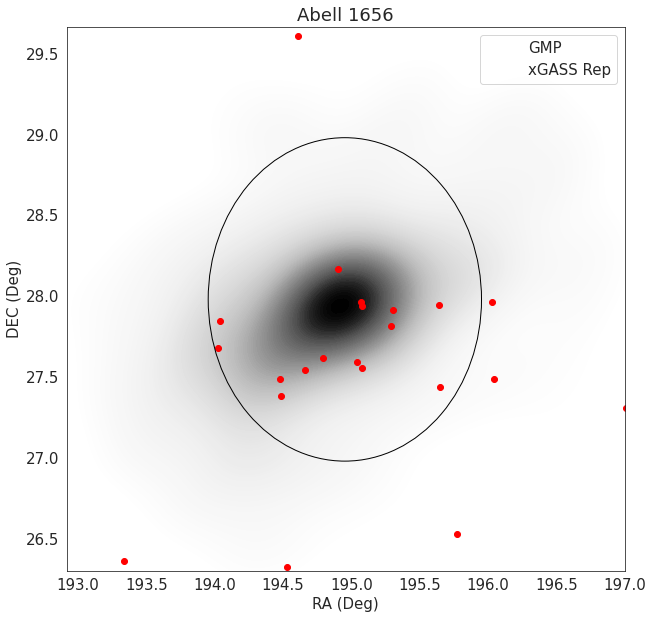

In [ ]:
figure, ax = plt.subplots(figsize = (10,10))
sb.kdeplot(df_coma.RAJ2000.values, df_coma.DEJ2000.values, 
           shade = 'fill', ax = ax, cmap="Greys", levels = 150, label = '_no_legend_')
ax.scatter(tab_rep['RA'].value, tab_rep['DEC'].value, c ='red')
c = plt.Circle([194.953054, 27.980694], radius = 1.,fill = False, color = 'black')
ax.add_artist(c)
x_min = df_coma.RAJ2000.min()
x_max = df_coma.RAJ2000.max()
y_min = df_coma.DEJ2000.min()
y_max = df_coma.DEJ2000.max()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('RA (Deg)')
ax.set_ylabel('DEC (Deg)')
ax.set_title('Abell 1656')
ax.legend(['GMP', 'xGASS Rep'])

In [ ]:
tab_HI_def

objID,specID,RA_1,Dec_1,lgM,lgssfr,GASS,AGCnr,SDSS,PLATEID,MJD,FIBERID,RA_2,DEC_2,zSDSS,Dlum,lgMstar,expAB_r,model_r,merr_r,ext_r,petrR50_r,petrR90_r,petrR50_z,lgmust,CINDX,INCL,NUVr,lgSFR_tot_median,SFR_best,SFRerr_best,SFRcase_best,HIsrc,HI_FLAG,xGASSDR,zHI,W50cor,lgMHI,lgGF,HIconf_flag,weight,group_id_B,NYU_id,env_code_B,Ngal_B,yang_shred_code,logMh_Mst_B,lvir_ratB,Separation,lgMH_Mst_pred,HI_Def
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,
int64,int64,float64,float64,float32,float32,int32,int32,bytes19,int16,int32,int16,float64,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int16,int16,int16,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,float32,float32,float64,float32,float32
1237667212674990144,3056328002396761015,179.95672,30.844423,10.04,-11.81,111028,0,J115949.61+305039.9,2224,53815,607,179.95673,30.84442,0.010369005,44.8,10.004167,0.838142,13.7024,0.0019,0.0497,5.4,16.29,4.86,9.18,3.02,33.8,5.12,-1.856422,0.03845919,0.0,9,4,99,4,0.0,0.0,8.108,-1.896,-99.0,0.655,46623,2178616,2,2,0,0.0,-99.0,0.03274080416347465,-1.0768514,0.81914866
1237651755096145961,2427899932518133812,207.63389,3.194152,10.95,-10.64,7058,231510,J135032.13+031138.9,530,52026,539,207.6339,3.19415,0.03241,142.2,10.838,0.813495,13.8073,0.0021,0.0843,9.88,18.64,9.31,8.48,1.89,36.4,3.11,0.23778632,2.7146702,0.2232121,1,3,1,1,0.032442,153.0,9.326,-1.512,0.0,0.426,93611,292127,1,1,0,12.4392,-4.5163727,0.036658100642551476,-0.6389611,0.8730389
1237652944780460151,-99,346.99134,15.415343,10.12,-10.91,11249,332433,J230757.92+152455.2,743,52262,459,346.99133,15.41534,0.03624,159.5,10.113,0.791285,16.6068,0.0054,0.643,2.78,6.69,2.93,8.67,2.41,38.6,-99.0,-1.3992907,0.19429395,0.0,9,4,99,3,0.0,0.0,8.705,-1.408,-99.0,0.564,105610,354444,1,1,0,0.0,-99.0,0.03634650249000735,24.82154,26.229542
1237652944784523441,3887277318016605521,356.69232,16.043083,11.27,-11.43,11770,330909,J234646.15+160235.0,748,52233,570,356.69232,16.04308,0.04162,183.9,11.309,0.784743,14.0077,0.002,0.0791,5.45,16.52,4.94,9.29,3.03,39.2,5.16,-0.94545436,0.63942826,0.18780197,2,4,99,2,0.0,0.0,9.375,-1.934,-99.0,0.143,22804,354700,2,2,0,13.2926,-1.8909942,0.010799999996903249,-1.3966079,0.53739214
1237654879128715491,2428357329355286477,220.24709,3.137092,10.97,-11.82,9704,9463,J144059.30+030813.5,586,52023,50,220.24709,3.13709,0.02654,116.0,10.948,0.321329,13.8675,0.0027,0.0951,6.33,17.22,5.79,9.17,2.72,75.1,5.53,-0.75573766,0.3736735,0.1771128,1,4,99,1,0.0,0.0,9.069,-1.879,-99.0,0.398,16,485878,0,148,0,14.3117,-0.38930842,0.007199999999843832,-1.3693712,0.5096288
1237662636905201755,3758889544264457104,223.74361,11.698969,10.89,-11.22,38935,240932,J145458.46+114156.2,1716,53827,327,223.7436,11.69897,0.03048,133.6,10.899,0.576311,13.9735,0.002,0.0897,4.02,14.43,3.61,9.42,3.59,56.5,5.13,-0.8221372,0.58817637,0.18682326,1,4,99,3,0.0,0.0,8.908,-1.991,-99.0,0.426,616,1428785,0,21,0,13.7195,-0.17011485,0.03543549432143069,-1.3560934,0.63490665
1237661086419845276,3715507213481017975,125.36168,24.453087,10.14,-10.32,108058,0,J082126.80+242711.1,1585,52962,559,125.36168,24.45309,0.019781524,86.0,10.120649,0.621241,14.7401,0.0024,0.0891,4.21,13.23,3.87,8.94,3.14,53.1,4.41,-0.16296995,0.33671436,0.1387624,1,4,99,4,0.0,0.0,8.438,-1.683,-99.0,0.564,235847,1140990,1,1,0,0.0,-99.0,0.010799999996903249,-0.9747913,0.7082087
1237668494708178980,6378867492299736419,176.09641,16.551269,9.759,-11.75,111024,0,J114423.13+163304.5,2508,53875,131,176.09641,16.55127,0.012905144,55.8,9.656888,0.679742,14.7332,0.0025,0.0895,3.81,9.72,3.58,8.91,2.55,48.5,5.1,-2.0091743,0.011683541,0.040597625,2,4,99,4,0.0,0.0,8.05,-1.607,-99.0,1.769,458224,2393346,1,1,0,0.0,-99.0,0.0035999999913344186,-1.0522261,0.5547739


[WARNING]: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation. (FutureWarning)
  FutureWarning



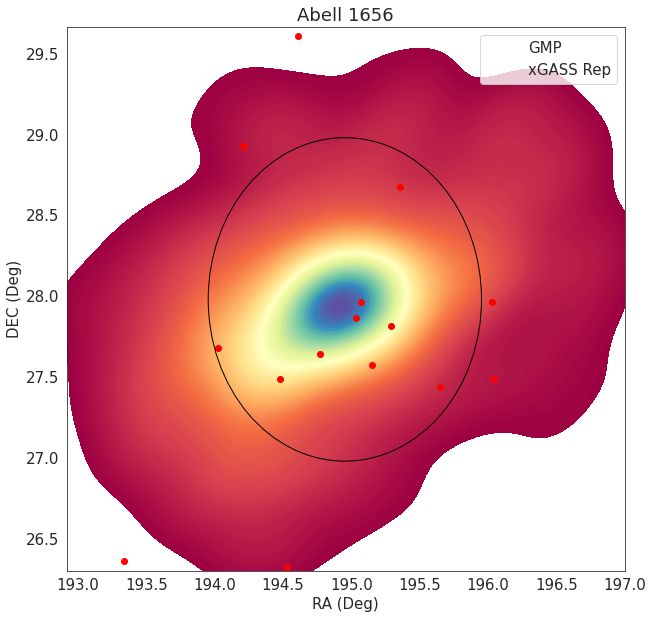

In [ ]:
figure, ax = plt.subplots(figsize = (10,10))
sb.kdeplot(df_coma.RAJ2000.values, df_coma.DEJ2000.values, 
           shade = 'fill', ax = ax, cmap="Spectral", levels = 150, label = '_no_legend_')
ax.scatter(tab_HI_def['RA_1'].value, tab_HI_def['Dec_1'].value, c ='red')
c = plt.Circle([194.953054, 27.980694], radius = 1.,fill = False, color = 'black')
ax.add_artist(c)
x_min = df_coma.RAJ2000.min()
x_max = df_coma.RAJ2000.max()
y_min = df_coma.DEJ2000.min()
y_max = df_coma.DEJ2000.max()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('RA (Deg)')
ax.set_ylabel('DEC (Deg)')
ax.set_title('Abell 1656')
ax.legend(['GMP', 'xGASS Rep'])

[WARNING]: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation. (FutureWarning)
  FutureWarning



Text(0.5, 1.0, 'Abell 1656')

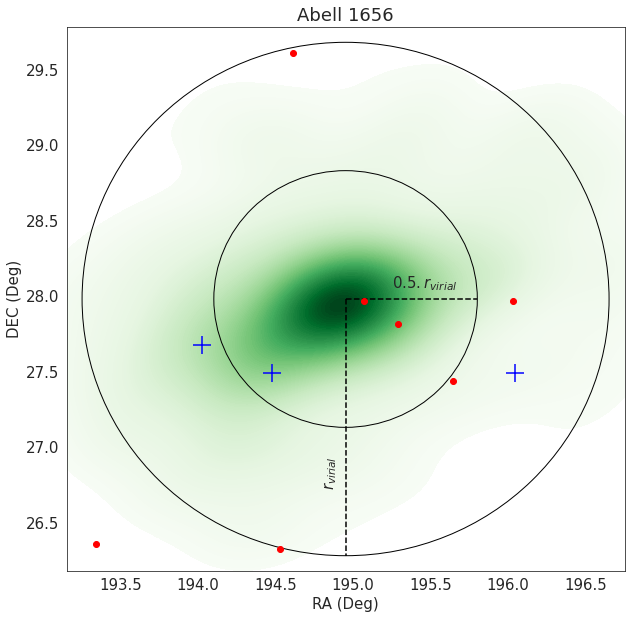

In [ ]:
figure, ax = plt.subplots(figsize = (10,10))
ax.scatter(df_noSF['RA_1'].values, df_noSF['Dec_1'].values, c ='red',
           zorder = 100)
ax.scatter(df_SF['RA_1'].values, df_SF['Dec_1'].values, marker = '+',c ='blue',
           zorder = 101 ,s = 300)
ax.plot([194.953054,194.953054 + 1.7/2], [27.980694,27.980694],'--',color = 'black', label = '_nolegend_')
ax.plot([194.953054,194.953054], [27.980694,27.980694 - 1.7 ],'--',color = 'black', label = '_nolegend_')
sb.kdeplot(df_coma.RAJ2000.values, df_coma.DEJ2000.values, 
           shade = 'fill', ax = ax, cmap="Greens", levels = 150, label = '_no_legend_')
c = plt.Circle([194.953054, 27.980694], radius = 1.7/2,fill = False, color = 'black')
ax.add_artist(c)

c = plt.Circle([194.953054, 27.980694], radius = 1.7,fill = False, color = 'black')
ax.add_artist(c)

ax.annotate(r'$0.5.r_{virial}$',(195.25, 28.05))
ax.annotate(r'$r_{virial}$',(194.8, 26.75), rotation = 90)
x_min = 194.953054-1.8
x_max = 194.953054+1.8
y_min = 27.980694 - 1.8
y_max = 27.980694 + 1.8
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('RA (Deg)')
ax.set_ylabel('DEC (Deg)')
ax.set_title('Abell 1656')
#plt.legend(['Quenched','Star-forming'])

In [ ]:
from astropy.coordinates import angular_separation

In [ ]:
w = np.pi/180
dist = angular_separation(194.953054*w, 27.980694*w, tab_HI_def['RA_1'].value*w, tab_HI_def['Dec_1'].value*w)/w

(0.4, 1.0)

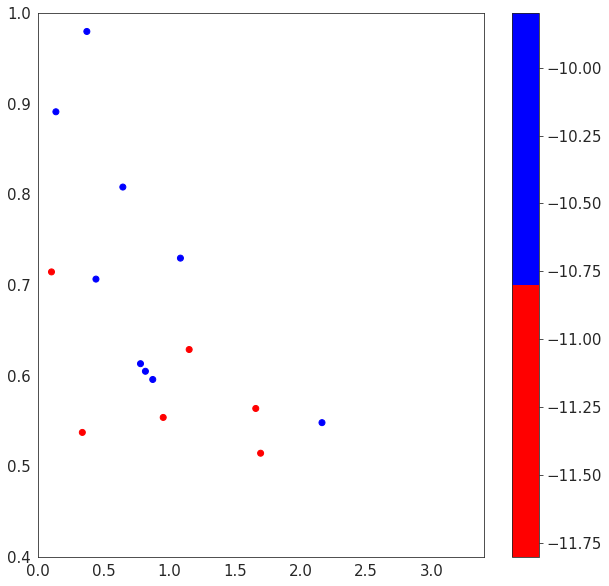

In [ ]:
x = dist
y = tab_HI_def['HI_Def']

cmap = colors.ListedColormap(['red','blue'])
img = plt.scatter(x,y, c =tab_HI_def['lgssfr'] , cmap = cmap, vmin = -11.8, vmax = -9.8)
cb = plt.colorbar(img)
plt.xlim(0,3.4)
plt.ylim(0.4,1)

### **xCold GASS**

In [ ]:
tab_CO = Table.read('data/xCOLD_xGASS.fits')
tab_M_CO = Table.read('data/xCOLD_GASS_MaNGA.fits')

m = []
for i in tab_M_CO['mangaid']:
  m.append(i.split()[0])
df_M_CO = tab_M_CO.to_pandas()
df_M_CO['mangaid'] = m

df_CO_HDSF= pd.merge(df_SF,df_M_CO, on = 'mangaid')
df_CO_HDQ  = pd.merge(df_noSF, df_M_CO, on = 'mangaid')

In [ ]:
df_CO_HDQ.keys()

Index(['plateifu_x', 'mangaid', 'RA_1', 'Dec_1', 'zSDSS', 'Dlum', 'lgMstar',
       'petrR50_r', 'petrR90_r', 'petrR50_z', 'lgmust', 'lgM', 'lgssfr',
       'NUVr', 'lgSFR_tot_median', 'SFR_best', 'SFRerr_best', 'SFRcase_best',
       'zHI', 'W50cor', 'lgMHI', 'lgGF', 'weight', 'Ngal_B', 'logMh_Mst_B',
       'lvir_ratB', 'lgMH_Mst_pred', 'HI_Def', 'PLATEID', 'RA', 'DEC',
       'Z_SDSS', 'LUMDIST', 'INCL', 'NUVR', 'R50KPC', 'LOGMSTAR', 'LOGMUST',
       'CINDX', 'WEIGHT', 'LOGSFR_MPAJHU', 'LOGSFR_SED', 'LOGSFR_BEST',
       'LOGSFR_ERR', 'FLAG_IRAS', 'LOGLIR_IRAS', 'IRCOL_IRAS', 'N2HA', 'O3HB',
       'AGNCLASS', 'Z_PP04_N2', 'Z_PP04_O3N2', 'Z_MZR', 'FLAG_CO', 'XCO',
       'XCO_A17', 'XCO_A17_ERR', 'ICO', 'ICO_ERR', 'ICO_COR', 'ICO_COR_ERR',
       'LCO', 'LCO_ERR', 'LCO_COR', 'LCO_COR_ERR', 'RMS_CO', 'SN_CO', 'WCO',
       'WCO_FLAG', 'Z_CO', 'WCO_TFR', 'WCO_TFR_ERR', 'LOGMH2', 'LOGMH2_ERR',
       'LIM_LOGMH2', 'LOGMH2MS', 'FLAG_CO21', 'ICO21', 'ICO21_ERR', 'LCO21',
       'LCO21_E

In [ ]:
df_noSF[['mangaid', 'lgMHI']]

,mangaid,lgMHI
0,1-119212,9.375
11,1-623756,8.324
16,1-230042,9.470
30,1-591260,8.106
31,1-78688,7.979
61,1-404358,8.357
62,1-457185,8.065
64,1-82382,9.386
78,1-335271,9.294
79,1-42274,8.141


In [ ]:
df_CO_HDQ[['mangaid', 'lgMHI','LOGMH2']]

,mangaid,lgMHI,LOGMH2
0,1-384400,8.329,0.000000
1,1-115435,8.637,8.765565
2,1-115158,8.732,0.000000
3,1-456399,7.999,0.000000
4,1-42184,9.590,9.572013


Text(0, 0.5, 'log $M_{H2}/M_{HI} $')

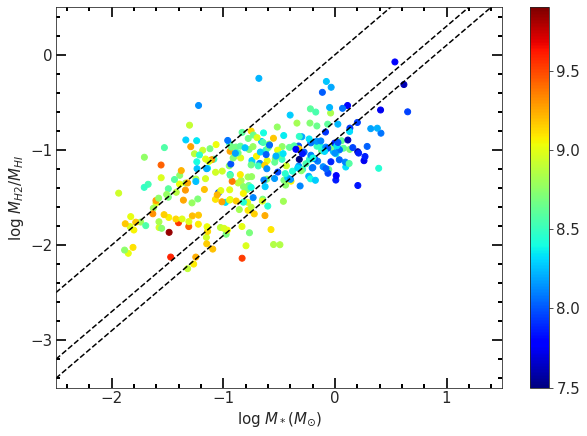

In [ ]:
fig = plt.figure(figsize = (10,7))
ax  = fig.subplots()
x =  tab_CO['lgMHI'] - tab_CO['LOGMSTAR']
y = tab_CO['LOGMH2'] - tab_CO['LOGMSTAR']
img = ax.scatter(x,y, c = tab_CO['LOGMUST'], cmap = 'jet', vmin = 7.5, vmax = 9.9)
plt.colorbar(img, ax = ax)
x = df_CO_HDSF['lgMHI'] - df_CO_HDSF['LOGMSTAR']
y = df_CO_HDSF['LOGMH2'] - df_CO_HDSF['LOGMSTAR']
ax.scatter(x,y)


x= np.linspace(-2.5,1.5)
y=x

ax.plot(x,y,'--', color = 'black', label = '_nolegend_')

y = x-0.7
ax.plot(x,y,'--', color = 'black', label = '_nolegend_')

y = x-0.9
ax.plot(x,y,'--', color = 'black', label = '_nolegend_')


ax.set_xlim(-2.5,1.5)
ax.set_ylim(-3.5,0.5)

ax.set_xticks([-2,-1,0,1])
ax.set_yticks([-3,-2,-1,0])


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,
               right = True,bottom = True, left = True)
ax.tick_params(which='major', length=10,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_xlabel(r'log $M_* (M_{\odot})$')
ax.set_ylabel(r'log $M_{H2}/M_{HI} $')

In [ ]:
df_CO_HDSF

,plateifu_x,mangaid,RA_x,DEC_x,zSDSS,Dlum,lgMstar,expAB_r,model_r,merr_r,...,WCO21_FLAG,Z_CO21,FLAG_APEX,ICO_APEX,LCO_APEX,RMS_APEX,SN_APEX,WCO_APEX,ZCO_APEX,plateifu_y


### **SDSS Spectra**

In [ ]:
df_spec = pd.read_csv('data/HI_Def_spec.csv')
df_spec = df_spec.rename(columns = {'name' : 'mangaid'})

In [ ]:
df_spec['spec_class'] = ['Broadline', 'Star-Forming', 'Star-Forming','Broadline','Broadline',
 'Star-Forming','Broadline', 'Broadline','Star-Forming', 'Starburst',
 'Star-Forming', 'Star-Forming', 'Broadline','        ','Broadline',
 'Broadline', 'Star-Forming', 'Broadline', 'Broadline', '         ',
 'Star-Forming',  'Broadline', '        ', '         ','AGN',
  'Broadline',  'AGN', '         ' ,  'Broadline','Star-Forming',
 'Broadline', '       ', 'Broadline', '   ']

In [ ]:
cl = []
for mangaid in df_spec.mangaid:
  if mangaid in df_SF.mangaid.values:
    cl.append(1)
  else:
    cl.append(0)

In [ ]:
def SNR_cut(df,col,value):
  SNR =  df[col]/np.sqrt(df[col + '_err'])
  return np.where(SNR>=value , df[col],np.nan)

In [ ]:
df_spec['MaNGA_class'] = cl

lines = ['nii_6584_flux','h_alpha_flux','h_beta_flux','oiii_5007_flux'
          ,'oi_6300_flux','sii_6717_flux','h_alpha_eqw']
em_ab = []
for i, row in df_spec.iterrows():
  if row['h_alpha_eqw']>0:
    em_ab.append('Emission')
  else:
    em_ab.append('Absorption')

for i in lines:
  df_spec[i] = np.abs(df_spec[i].values)
  if i!= 'h_alpha_eqw':
    df_spec[i] = SNR_cut(df_spec, i,3)
df_spec['f_type'] = em_ab

Text(0.45, -0.4, 'PG')

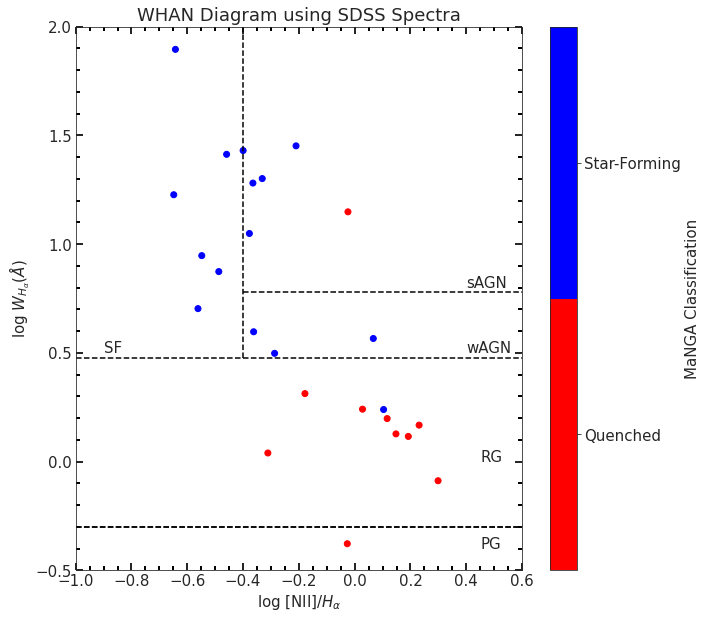

In [ ]:
fig, ax = plt.subplots()

x = np.log10(df_spec['nii_6584_flux'].values/df_spec['h_alpha_flux'].values)
y = np.log10(df_spec['h_alpha_eqw'].values)

cmap = colors.ListedColormap(['red','blue'])

img = ax.scatter(x,y, c= df_spec['MaNGA_class'], cmap = cmap, vmin = -0.5, vmax =1.5)
ax.set_xlim(-1,0.6)
ax.set_ylim(-0.5, 2)
cb = plt.colorbar(img, ax = ax, label = 'MaNGA Classification')
cb.set_ticks([0,1])
cb.set_ticklabels(['Quenched','Star-Forming'])

ax.plot([-1,0.6],[np.log10(3),np.log10(3)], '--', color = 'black')
ax.plot([-1,0.6],[np.log10(0.5),np.log10(0.5)], '--', color = 'black')
ax.plot([-1,0.6],[np.log10(0.5),np.log10(0.5)], '--', color = 'black')

ax.plot([-0.4,-0.4],[np.log10(3),2], '--', color = 'black')
ax.plot([-0.4,0.6],[np.log10(6),np.log10(6)], '--', color = 'black')
"""
psf = (logniiha < -0.4) & (ewha.value > 3)                        # Pure Star Forming
  sagn = (logniiha > -0.4) & (ewha.value > 6)                       # Strong AGN
  wagn = (logniiha > -0.4) & ((ewha.value > 3) & (ewha.value < 6))  # Weak AGN
  rg = ewha.value < 3                                               # Retired Galaxy  
  pg = (ewha.value < 0.5) & (ewnii.value < 0.5)                     # Passive Galaxy
"""

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               left = True, bottom = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_title('WHAN Diagram using SDSS Spectra')
ax.set_xlabel( r'log [NII]/$H_{\alpha}$')
ax.set_ylabel(r'log $W_{H_{\alpha}}(\AA)$')

ax.annotate('SF',(-0.9,0.5))
ax.annotate('wAGN',(0.4,0.5))
ax.annotate('sAGN',(0.4,0.8))
ax.annotate('RG',(0.45,0))
ax.annotate('PG',(0.45,-0.4))

In [ ]:
whan_class = []
for i,row in df_spec.iterrows():
  x = np.log10(np.abs(row['nii_6584_flux']/row['h_alpha_flux']))
  y = np.log10(np.abs(row['h_alpha_eqw']))

  if y<= np.log10(0.5):
    whan_class.append('PG')
  elif y> np.log10(0.5) and y< np.log10(3):
    whan_class.append('RG')
  elif x<=-0.4:
    whan_class.append('SF')
  elif x>-0.4 and y<=np.log10(6):
    whan_class.append('wAGN')
  elif x>-0.4 and y>np.log10(6):
    whan_class.append('sAGN')
  
df_spec['WHAN_class'] = whan_class

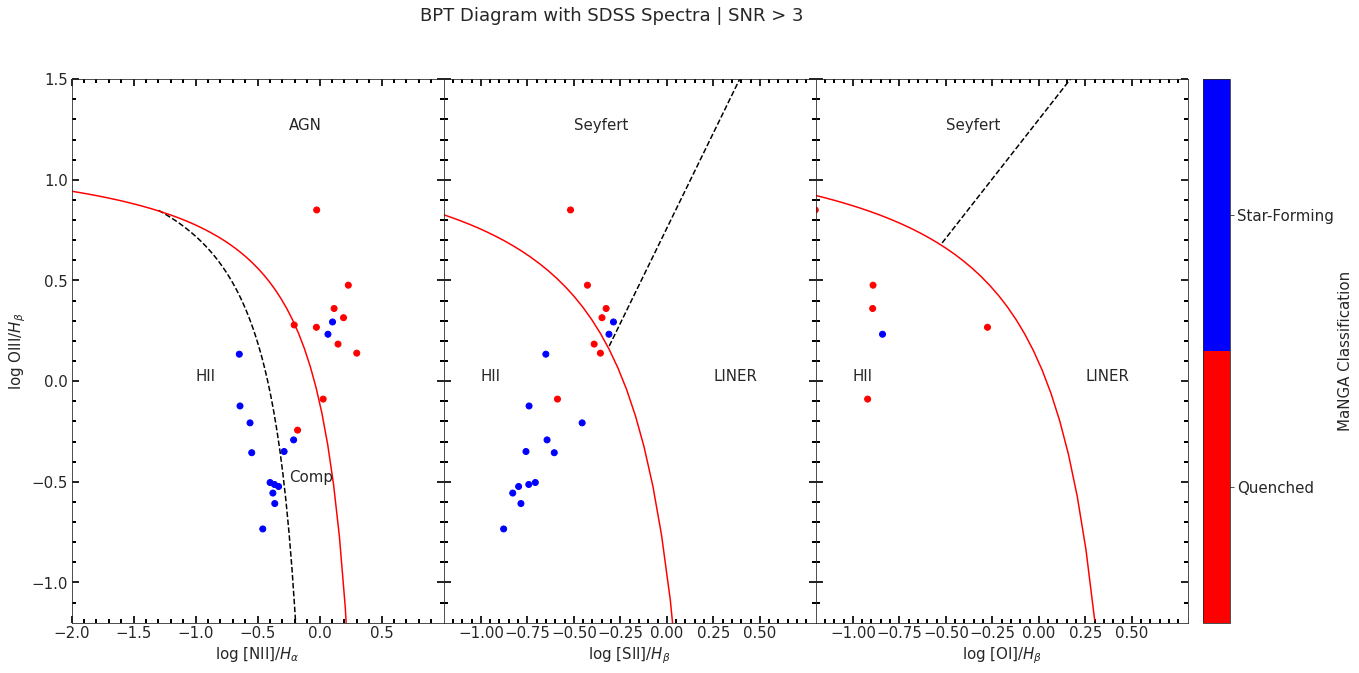

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (20,10), sharey = True)
cmap = colors.ListedColormap(['red','blue'])

#BPT I

x = np.log10(df_spec['nii_6584_flux'].values/df_spec['h_alpha_flux'].values)
y = np.log10(df_spec['oiii_5007_flux'].values/df_spec['h_beta_flux'].values)

img = ax[0].scatter(x,y, c= df_spec['MaNGA_class'], cmap = cmap, vmin = -0.5, vmax =1.5)

bpt_class_I = []
for i,j in zip(x,y):
  if np.isnan(i)  or np.isnan(j):
    bpt_class_I.append('LowSNR')
  elif j< 0.61/(i-0.05)+1.3:
    bpt_class_I.append('SF')
  elif j >= 0.61/(i-0.05)+1.3 and j < 0.61/(i-0.47)+1.19 :
    bpt_class_I.append('Comp')
  elif j >= 0.61/(i-0.47)+1.19:
    bpt_class_I.append('AGN')

x = np.linspace(-1.3,-0.1)
y  = 0.61/(x-0.05)+1.3

ax[0].plot(x,y, '--',color = 'black')

x = np.linspace(-2, 0.3)
y  = 0.61/(x-0.47)+1.19

ax[0].plot(x,y, '-',color = 'red')

ax[0].set_xticks(np.arange(-2,0.55, 0.5))

ax[0].set_xlim(-2,1)
ax[0].set_ylim(-1.2, 1.5)

ax[0].annotate('HII',(-1,0))
ax[0].annotate('Comp',(-0.25,-0.5))
ax[0].annotate('AGN',(-0.25,1.25))

ax[0].set_xlabel( r'log [NII]/$H_{\alpha}$')
ax[0].set_ylabel(r'log OIII/$H_{\beta}$')


# BPT II 

x = np.log10(df_spec['sii_6717_flux'].values/df_spec['h_alpha_flux'].values)
y = np.log10(df_spec['oiii_5007_flux'].values/df_spec['h_beta_flux'].values)

img = ax[1].scatter(x,y, c= df_spec['MaNGA_class'], cmap = cmap, vmin = -0.5, vmax =1.5)


bpt_class_II = []
for i,j in zip(x,y):
  if np.isnan(i)  or np.isnan(j):
    bpt_class_II.append('LowSNR')
  elif j< 0.72/(i-0.32) + 1.3:
    bpt_class_II.append('SF')
  elif j >= 0.72/(i-0.32) + 1.3 and j < 1.89*i + 0.76 :
    bpt_class_II.append('LINER')
  elif j >= 0.72/(i-0.32) + 1.3 and j >= 1.89*i + 0.76:
    bpt_class_II.append('Seyfert')

x = np.linspace(-2, 0.3)
y  = 0.72/(x-0.32) + 1.3

ax[1].plot(x,y, '-',color = 'red')

x = np.linspace(-0.31, 0.8)
y  = 1.89*x + 0.76
ax[1].plot(x,y, '--',color = 'Black')

ax[1].set_xlim(-1.2,0.8)

ax[1].set_xticks(np.arange(-1,0.75,0.25))

ax[1].annotate('HII',(-1,0))
ax[1].annotate('LINER',(0.25,0))
ax[1].annotate('Seyfert',(-0.5,1.25))

ax[1].set_xlabel(r'log [SII]/$H_{\beta}$')

# BPT III

x = np.log10(df_spec['oi_6300_flux'].values/df_spec['h_alpha_flux'].values)
y = np.log10(df_spec['oiii_5007_flux'].values/df_spec['h_beta_flux'].values)

img = ax[2].scatter(x,y, c= df_spec['MaNGA_class'], cmap = cmap, vmin = -0.5, vmax =1.5)

bpt_class_III = []

for i,j in zip(x,y):
  if np.isnan(i)  or np.isnan(j):
    bpt_class_III.append('LowSNR')
  elif j< 0.73/(i-0.59) + 1.33:
    bpt_class_III.append('SF')
  elif j >= 0.73/(i-0.59) + 1.33 and j < 1.18*i + 1.30 :
    bpt_class_III.append('LINER')
  elif j >= 0.73/(i-0.59) + 1.33 and j >= 1.18*i + 1.30:
    bpt_class_III.append('Seyfert')


x = np.linspace(-2, 0.3)
y  = 0.73/(x-0.59) + 1.33
ax[2].plot(x,y, '-',color = 'red')
x = np.linspace(-0.52, 0.8)
y  = 1.18*x + 1.30
ax[2].plot(x,y, '--',color = 'Black')

ax[2].set_xlim(-1.2,0.8)

ax[2].set_xticks(np.arange(-1,0.75,0.25))

ax[2].annotate('HII',(-1,0))
ax[2].annotate('LINER',(0.25,0))
ax[2].annotate('Seyfert',(-0.5,1.25))

ax[2].set_xlabel(r'log [OI]/$H_{\beta}$')

for a in ax :

  a.xaxis.set_minor_locator(AutoMinorLocator())
  a.yaxis.set_minor_locator(AutoMinorLocator())

  a.tick_params(which='both', width=2,direction="in", top = True,right = True,
                left = True, bottom = True)
  a.tick_params(which='major', length=7,direction="in")
  a.tick_params(which='minor', length=4, color='black',direction="in")


cb = plt.colorbar(img, ax = ax, label = 'MaNGA Classification', anchor = (1.3,0))
cb.set_ticks([0,1])
cb.set_ticklabels(['Quenched','Star-Forming'])
fig.suptitle('BPT Diagram with SDSS Spectra | SNR > 3')
plt.subplots_adjust(wspace = 0)

In [ ]:
bpt_class = []
for i,j,k in zip(bpt_class_I, bpt_class_II, bpt_class_III):
  if i ==j == k=='SF':
    bpt_class.append('SF')
  elif i =='Comp' and j==k =='SF':
    bpt_class.append('Comp')
  elif (i=='AGN') and (j=='LINER'  or j=='Seyfert') and (k=='LINER'  or k=='Seyfert') :
    bpt_class.append('AGN')
  elif i=='AGN' and j==k=='Seyfert':
    bpt_class.append('Seyfert')
  elif i == 'LowSNR' or j == 'LowSNR' or 'LowSNR':
    bpt_class.append('Invalid')
  else:
   bpt_class.append('Ambiguous')

In [ ]:
df_spec['BPT_class'] = bpt_class

In [ ]:
df_spec_SF = df_spec[df_spec['MaNGA_class']==1]
df_spec_noSF = df_spec[df_spec['MaNGA_class']==0]

In [ ]:
df_spec_SF[['specObjID','mangaid','spec_class','WHAN_class','BPT_class']]

,specObjID,mangaid,spec_class,WHAN_class,BPT_class
1,1784705058789681152,1-298715,Star-Forming,sAGN,SF
2,484217805537830912,1-42704,Star-Forming,SF,SF
5,835449654681298944,1-117014,Star-Forming,sAGN,Comp
8,2522048016181913600,1-456339,Star-Forming,sAGN,SF
9,2523206632364599296,1-456772,Starburst,SF,SF
10,1783566239302445056,1-298482,Star-Forming,SF,SF
11,2523317408161097728,1-457009,Star-Forming,SF,SF
12,828776717907683328,1-115377,Broadline,wAGN,SF
16,834306987188578304,1-116725,Star-Forming,sAGN,SF
20,484223577973876736,1-42718,Star-Forming,SF,Invalid


In [ ]:
len(df_spec_noSF)

19

## **LSB**

In [ ]:
!wget https://data.sdss.org/sas/dr17/manga/photo/pymorph/1.1.1/manga-pymorph-DR17.fits

--2022-09-21 06:36:57--  https://data.sdss.org/sas/dr17/manga/photo/pymorph/1.1.1/manga-pymorph-DR17.fits
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13878720 (13M) [application/octet-stream]
Saving to: ‘manga-pymorph-DR17.fits.1’

manga-pymorph-DR17. 100%[===================>]  13.24M  1.41MB/s    in 9.4s    

2022-09-21 06:37:07 (1.40 MB/s) - ‘manga-pymorph-DR17.fits.1’ saved [13878720/13878720]



In [ ]:
def filter_LSB(tab, hdul):

  tab['R_s']        = tab['A_HL_SE_DISK']/( 1.9992*tab['N_SE_DISK'] - 0.3271)
  tab['mu_disk_0']  = tab['M_SE_DISK'] + 2.5*np.log10(2*np.pi*tab['R_s']**2) 
  tab['mu_disk_c0'] = tab['mu_disk_0'] +2.5*np.log10(tab['BA_SE_DISK']) -  10*np.log10(1 + tab['Z'])
  tab_LSB           = tab[tab['mu_disk_c0']>=21]

  tab_LSB_r = tab_LSB[['MANGA_ID'      ,'PLATEIFU'   ,'OBJID','RA','DEC'          
                     ,'Z','FLAG_FAILED_S',
         'FLAG_FAILED_SE','FLAG_FIT'   ,'M_SE_BULGE','A_HL_SE_BULGE','N_SE_BULGE',
         'BA_SE_BULGE'   ,'PA_SE_BULGE','M_SE_DISK' ,'A_HL_SE_DISK' , 'R_s',
         'N_SE_DISK'     , 'BA_SE_DISK','PA_SE_DISK', 
         'mu_disk_c0']].to_pandas()

  tab_g        = Table.read(hdul[1])
  tab_g['R_s'] = tab_g['A_HL_SE_DISK']/( 1.9992*tab_g['N_SE_DISK'] - 0.3271)
  tab_g['mu_disk_0'] = tab_g['M_SE_DISK'] + 2.5*np.log10(2*np.pi*tab_g['R_s']**2)
  tab_g['mu_disk_c0']  = tab_g['mu_disk_0'] +2.5*np.log10(tab_g['BA_SE_DISK']) -  10*np.log10(1 + tab_g['Z'])

  tab_g = tab_g[['MANGA_ID'      ,'PLATEIFU'   ,'OBJID','RA','DEC'          ,'Z','FLAG_FAILED_S',
          'FLAG_FAILED_SE','FLAG_FIT'   ,'M_SE_BULGE','A_HL_SE_BULGE','N_SE_BULGE',
          'BA_SE_BULGE'   ,'PA_SE_BULGE','M_SE_DISK' ,'A_HL_SE_DISK' , 'R_s',
          'N_SE_DISK'     , 'BA_SE_DISK','PA_SE_DISK', 
          'mu_disk_c0']].to_pandas()

  tab_LSB_g = tab_LSB_r[0:0]
  for i in tab_LSB_r['MANGA_ID']:
    if i in tab_LSB_r['MANGA_ID'].values:
      tab_LSB_g = tab_LSB_g.append(tab_g[tab_g['MANGA_ID']==i])

  tab_i        = Table.read(hdul[3])
  tab_i['R_s'] = tab_i['A_HL_SE_DISK']/( 1.9992*tab_i['N_SE_DISK'] - 0.3271)
  tab_i['mu_disk_0'] = tab_i['M_SE_DISK'] + 2.5*np.log10(2*np.pi*tab_i['R_s']**2)
  tab_i['mu_disk_c0']  = tab_i['mu_disk_0'] +2.5*np.log10(tab_i['BA_SE_DISK']) -  10*np.log10(1 + tab_i['Z'])

  tab_i = tab_i[['MANGA_ID'      ,'PLATEIFU'   ,'OBJID','RA','DEC'          ,'Z','FLAG_FAILED_S',
          'FLAG_FAILED_SE','FLAG_FIT'   ,'M_SE_BULGE','A_HL_SE_BULGE','N_SE_BULGE',
          'BA_SE_BULGE'   ,'PA_SE_BULGE','M_SE_DISK' ,'A_HL_SE_DISK' , 'R_s',
          'N_SE_DISK'     , 'BA_SE_DISK','PA_SE_DISK', 
          'mu_disk_c0']].to_pandas()

  tab_LSB_i = tab_LSB_r[0:0]
  for i in tab_LSB_r['MANGA_ID']:
    if i in tab_LSB_r['MANGA_ID'].values:
      tab_LSB_i = tab_LSB_i.append(tab_g[tab_g['MANGA_ID']==i])
  return tab_LSB_g, tab_LSB_r, tab_LSB_i

In [ ]:
hdul = fits.open('manga-pymorph-DR17.fits')
tab    = Table.read(hdul[2])
tab_pym    = Table.read(hdul[2])

### **Sersic + Exp**

#### **$R_S<R_{SE}$**

In [ ]:
tab_SE = tab[tab['A_HL_SE_BULGE']<tab['A_HL_SE_DISK']]
tab_SE = tab_SE[tab_SE['FLAG_FIT']==2]

LSB_g1, LSB_r1, LSB_i1 = filter_LSB(tab_SE,hdul) 

[WARNING]: invalid value encountered in log10 (RuntimeWarning)



In [ ]:
len(LSB_r1)

821

#### **$R_S>R_{SE}$**

In [ ]:
tab_SE = tab[tab['A_HL_SE_BULGE']>tab['A_HL_SE_DISK']]
tab_SE = tab_SE[tab_SE['FLAG_FIT']==2]
tab_SE['N_SE_DISK'] = tab_SE['N_SE_BULGE']
tab_SE['A_HL_SE_DISK'] = tab_SE['A_HL_SE_BULGE']
tab_SE['M_SE_DISK'] = tab_SE['M_SE_BULGE']
tab_SE['BA_SE_DISK'] = tab_SE['BA_SE_BULGE']

LSB_g2, LSB_r2, LSB_i2 = filter_LSB(tab_SE,hdul) 

[WARNING]: invalid value encountered in log10 (RuntimeWarning)



In [ ]:
len(LSB_r2)

11

### **Sersic**

In [ ]:
tab_SE = tab[tab['A_HL_SE_BULGE']<tab['A_HL_SE_DISK']]
tab_SE = tab_SE[tab_SE['FLAG_FIT']==1]
tab_SE = tab_SE[tab_SE['FLAG_FIT']==1]

tab_SE['N_SE_DISK']    = tab_SE['N_S']
tab_SE['A_HL_SE_DISK'] = tab_SE['A_HL_S']
tab_SE['M_SE_DISK']    = tab_SE['M_S']
tab_SE['BA_SE_DISK']   = tab_SE['BA_S']

LSB_g3, LSB_r3, LSB_i3 = filter_LSB(tab_SE,hdul) 
len(LSB_r3)

[WARNING]: invalid value encountered in log10 (RuntimeWarning)



236

In [ ]:
len(LSB_r1) + len(LSB_r2) + len(LSB_r3)

1068

In [ ]:
LSB_r1.to_csv('LSB_r_SE_sersicbulge.csv')
LSB_r2.to_csv('LSB_r_SE_expbulge.csv')

LSB_r3.to_csv('LSB_r_S.csv')

In [ ]:
for i in df_HI_def.mangaid:
  if i in LSB_r1.MANGA_ID.values:
    print(i)
  if i in LSB_r2.MANGA_ID.values:
    print(i)
  if i in LSB_r3.MANGA_ID.values:
    print(i)

1-53952


# **Saving to Google Drive**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ls

'ASI POSTER 2021'/                 'Motivation Letter HU.gdoc'
'Bangalore Days'/                  'Motivation Letter_INAF.gdoc'
'Colab Notebooks'/                 'Motivation Letter_NCBJ.gdoc'
'Cover Letter.gdoc'                 PRNU_level_output.fits
'Cover Letter Uppsala.gdoc'        'Research Experience.gdoc'
'Dr. Chrisphin Karthick'/          'SDR data recording code.py'
'Dusty Galaxies in MaNGA'/         'Star forming Bars in S0 Galaxies'/
 galfit.feedme                     'Untitled document.gdoc'
 Jovian/                            WIN_20190220_09_54_10_Pro.mp4
'jvf-vhzv-iqn - Jun 4, 2022.gjam'   xgass/
'Letter for UWA.gdoc'


Choose a location in your drive

In [ ]:
cd '/content/gdrive/MyDrive/Dusty Galaxies in MaNGA/Maps'

/content/gdrive/MyDrive/Dusty Galaxies in MaNGA/Maps


In [ ]:
ids = [i[:-9] for i in os.listdir()]
ids

# **Maps with Mapplot**

## **Maps**

In [ ]:
download = 0
format   = 'png'

for plateifu in df_SF.plateifu:
 
  if not os.path.exists(f'{plateifu}'):
      os.mkdir(f'{plateifu}')

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()
  scale_s = optical.wcs.to_header()['PC2_2']*3600
  size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s

  # Physical Scale
  c          = 299792  # speed of light [km/s]
  H0         = 70  # [km s^-1 Mpc^-1]
  redshift   = maps.dapall['z']
  D          = c * redshift / H0  # approx. distance to galaxy [Mpc]
  dist_scale = 1 / 206265 * D * 1e3  # kpc per arc_secs
  d          = size_s*dist_scale
  r          = d/2  #kpc.
  
  # Optical Image
  fig = plt.figure(figsize = (10,10))
  ax1 = fig.add_subplot()
  ax1.grid(False)
  ax1.imshow(optical.data, extent = (-r,r,-r,r))
  ax1.grid(False)

  if download:
      fig.savefig(f'{plateifu}/SDSS_cutout',bbox_inches = 'tight',format=format)
  
  #------------------------------------------------------------------------------------------

  # Get DeCALS Image
  scale_s = optical.wcs.to_header()['PC2_2']*3600
  size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s
  img = Cutout_L(ra = optical.ra, dec = optical.dec, width = size_s, height=size_s, scale = size_s/512 )

  fig = plt.figure(figsize = (10,10))
  ax1 = fig.add_subplot()
  ax1.grid(False)
  ax1.imshow(img.image, extent = (-r,r,-r,r))
  ax1.grid(False)
  #ax1.annotate(f'manga {plateifu}',(512-512/3,512-512/20),weight='bold',family='serif',color = 'white')
  if download:
      fig.savefig(f'{plateifu}/legacy_cutout',bbox_inches = 'tight',format=format)

    # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

# H-alpha with optical contours

  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot( )
  ha = maps.emline_gflux_ha_6564

  d = size*dist_scale
  r = d/2

  ax3.grid(False)
  cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
  img = ax3.imshow(goodspax(ha),vmin=cbr[0],vmax=cbr[1],cmap='jet', extent = (-r,r,-r,r), origin = 'lower')
  ax3.grid(False)
  #ax3.set_autoscale_on(False)
  #ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  #ax3.annotate(r'H alpha Map',(len(ha)-len(ha)/3.5,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
  cb.set_label(r'$1\times10^{-17}ergcm^{-2}s^{-1}$')

  if download:
      fig.savefig(f'{plateifu}/H_alpha',bbox_inches = 'tight',format = format)
  #------------------------------------------------------------------------------------------

  # H-delta with optical contours

  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot( projection=maps.wcs,slices=('x','y',0))
  ha = maps.emline_gflux_hdel_4102

  ax3.grid(False)
  cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
  img = ax3.imshow(goodspax(ha),vmin=cbr[0],vmax=cbr[1],cmap='jet')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  #ax3.annotate(r'H delta Map',(len(ha)-len(ha)/3.5,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
  cb.set_label(r'$1\times10^{-17}ergcm^{-2}s^{-1}$')
  ax3.set_xlabel('pos.eq.ra')
  ax3.set_ylabel('pos.eq.dec')
  ax3.axis('off')

  if download:
      fig.savefig(f'{plateifu}/H_delta',bbox_inches = 'tight',format = format)
  #------------------------------------------------------------------------------------------

  # WHAN Map

  # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays
  nii=maps.emli40ne_gflux_nii_6585
  ha=maps.emline_gflux_ha_6564
  niiha = nii/ha
  ewha = maps['emline_sew_ha_6564']
  ewnii = maps['emline_sew_nii_6585']
  # take the log of the NII/Ha ratio
  logniiha = np.log10(niiha.value)

  # create the WHAN categories
  psf  = (logniiha < -0.4)  & (ewha.value > 3)
  sagn = (logniiha > -0.4)  & (ewha.value > 6)
  wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
  rg   = ewha.value < 3
  pg   = (ewha.value < 0.5) & (ewnii.value < 0.5) 

  # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
  value = ewha.value.copy()
  value[psf]  = 1     # pure star-forming 
  value[sagn] = 2     # strong agn
  value[wagn] = 3     # weak agn
  value[rg]   = 4     # retired galaxies
  value[pg]   = 5     # passive galaxies

  # Set ivar to 0 where the SNR < 1
  niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
  ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
  ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
  low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

  ivar = ewha.value.copy()
  ivar[low_snr] = 0
  value[low_snr] = np.nan

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # WHAN IFU
  fig = plt.figure(figsize = (10,10))
  ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax2.grid(False)
  cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
  nocov = ewha.pixmask.get_mask('NOCOV',dtype=np.bool)
  mask = np.where(nocov==True,np.nan,1)
  #fig, ax2, cb = mapplot.plot(value=value, ivar=ivar, mask=nocov, cmap=cmap,fig=fig,ax=ax2, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
  img = ax2.imshow(value,cmap=cmap,vmin=0.5,vmax=5.5)
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  #ax2.annotate(r'WHAN Map',(len(ha)-len(ha)/4,len(ha)-len(ha)/13),weight='bold',family='serif')

  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

  cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
  cb.set_ticks([1, 2, 3, 4, 5])
  cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')
  ax2.axis('off')
  if download:
      fig.savefig(f'{plateifu}/WHAN',bbox_inches = 'tight',format=format)
  #------------------------------------------------------------------------------------------
  
  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot()
  m, f ,a = maps.get_bpt(show_plot=False)
  
  SF = sf= m['sf']['global'].astype('float64')*5
  COMP = m['comp']['global'].astype('float64')*4
  LIN = m['liner']['global'].astype('float64')*3
  SEY = m['seyfert']['global'].astype('float64')*2
  AMB = m['ambiguous']['global'].astype('float64')*1
  
  bpt = SF + COMP + LIN + SEY + AMB
  
  cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])
  nocov = ewha.pixmask.get_mask('NOCOV')
  
  bpt[bpt==0]=np.nan
  
  #fig, ax4, cb = mapplot.plot(value=bpt, ivar = bpt, mask=nocov, cmap=cmap,fig=fig,ax=ax4, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
  img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5,extent = (-r,r,-r,r), origin = 'lower')
  #ax4.set_autoscale_on(False)
  #ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

  cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.824)
  cb.set_ticks([1, 2, 3, 4, 5])
  cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])

  #ax4.annotate(r'BPT Map',(len(ha)-len(ha)/4.6,len(ha)-len(ha)/12),weight='bold',family='serif')

  if download:
      fig.savefig(f'{plateifu}/BPT',bbox_inches = 'tight', format = format)
  
  #------------------------------------------------------------------------------------------

  dn=maps.specindex_dn4000

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)
  cbr=mapplot.plot(dapmap=dn,return_cbrange=True)
  img = ax4.imshow(goodspax(dn),vmin=cbr[0],vmax=cbr[1],cmap='jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.824)
  ax4.set_xlabel('pos.eq.ra')
  ax4.set_ylabel('pos.eq.dec')
  #ax4.annotate(r'Dn 4000 Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')

  ax4.axis('off')
  if download:
      fig.savefig(f'{plateifu}/DN4000',bbox_inches = 'tight',format = format)
      
  #------------------------------------------------------------------------------------------
  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  nii = maps.emline_gflux_nii_6585
  n2 = nii/ ha
  logn2 = np.log10(n2)
  logoh = 8.90 + 0.57 * logn2

  mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
  min_snr = 3.
  mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
  mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

  mask =  (mask_bad_data | mask_nii_low_snr | mask_ha_low_snr).astype(np.bool)
  ax3.grid(False)
  cbr = mapplot.plot(dapmap=logoh,mask=mask,return_cbrange=True)
  mask = np.where(mask==True,np.nan,1)
  img = ax3.imshow(logoh.value*mask,vmin=cbr[0],vmax=cbr[1],cmap = 'viridis')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824,label= '12+log(O/H)')
  ax3.set_xlabel('pos.eq.ra')
  ax3.set_ylabel('pos.eq.dec')
  #ax3.annotate(r'N2 Metallicity Map',(len(ha)-len(ha)/2.5,len(ha)-len(ha)/13),weight='bold',family='serif')
  ax3.axis('off')
  if download:
      fig.savefig(f'{plateifu}/Metallicity',bbox_inches = 'tight',format = format)
      
  #------------------------------------------------------------------------------------------
  
  hb = maps.emline_gflux_hb_4862
  ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')
  ha_sf    = ha*sf
  hb_sf    = hb*sf
  ha_hb_sf = ha_hb*sf
  
  z = maps.dapall['z']

  fa = ha_sf*1e-17*pow(10,2.468*0.934*np.log10(ha_hb_sf.value/2.86))
  D_L = cosmo.luminosity_distance(z).to(u.cm)
  Lha =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)
  SFR = 5.5e-42*Lha
  SFR = SFR.value*(u.solMass/u.year)
  cube = maps.getCube()

  M    = cube.vacs.firefly['mastar']

  M = cube.vacs.firefly['mastar']._make_map('stellar_mass')
  M = 10**np.where(M>-10,M,0)
  
  sSFR = np.log10(SFR.value/M)

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)

  ax4.imshow(sSFR, cmap = 'jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  if download:
    fig.savefig(f'{plateifu}/sSFR',bbox_inches = 'tight',format = format)

  ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)
  area = (ang_dist.value**2*maps.bin_area.value)
  area = area*(u.kpc**2)
  SFRD = SFR/area

  R   = maps.spx_ellcoo_elliptical_radius.value
  R_e = float(maps.header['reff'])

  x = (R/R_e)
  y = SFRD
  
  fig = plt.figure(figsize = (10,10))
  ax = fig.add_subplot()
  ax.scatter(x,y)
  ax.set_xlabel(r'$R/R_e$')
  ax.set_ylabel('SFRD ' + r'$M_{\odot}kpc^{-2}yr^{-1}$')
  
  ax.xaxis.set_minor_locator(AutoMinorLocator())
  ax.yaxis.set_minor_locator(AutoMinorLocator())

  ax.tick_params(which='both', width=2,direction="in")
  ax.tick_params(which='major', length=7,direction="in")
  ax.tick_params(which='minor', length=4, color='black',direction="in")
  
  if download:
      fig.savefig(f'{plateifu}/SFRD',bbox_inches = 'tight',format = format)
  
  #------------------------------------------------------------------------------------------  
  
  # OIII/OII map
  OIII_OII= maps.getMapRatio('emline_gflux','oiii_5008','oii_3729')

  fig = plt.figure(figsize = (10,10))   
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)
  cbr = mapplot.plot(dapmap = OIII_OII, return_cbrange = True)
  
  img = ax4.imshow(goodspax(OIII_OII),vmin=cbr[0],vmax=cbr[1],cmap = 'magma')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform = ax4.get_transform(optical.wcs), colors = 'red',levels = levels,zorder=11)
  cb=plt.colorbar(img, ax=ax4,anchor=(0,5),shrink=0.824)
  ax4.set_xlabel('pos.eq.ra')
  ax4.set_ylabel('pos.eq.dec')
  #ax4.annotate(r'OIII/OII Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
  ax4.axis('off')
  if download:
      fig.savefig(f'{plateifu}/OIII_OII',bbox_inches = 'tight',format = format)

  #------------------------------------------------------------------------------------------
      
    # H alpha EW
  ewha = maps['emline_sew_ha_6564']
  fig = plt.figure(figsize = (10,10))
  ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

  ax2.grid(False)
  cbr=mapplot.plot(dapmap=ewha,return_cbrange=True)
  img = ax2.imshow(goodspax(ewha),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='white',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')
  #ax2.annotate(r'H alpha EW Map',(len(ha)-len(ha)/2.7,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb.set_label(r'$\AA$')
  ax2.axis('off')
  if download:
      fig.savefig(f'{plateifu}/ewH_alpha',bbox_inches = 'tight')
  
  #--------------------------------------------------------------------------------------------
    # H delta EW
  ewha = maps.emline_sew_hdel_4102
  fig = plt.figure(figsize = (10,10))
  ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

  ax2.grid(False)
  cbr=mapplot.plot(dapmap=ewha,return_cbrange=True)
  img = ax2.imshow(goodspax(ewha),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='white',levels=levels,zorder=11)
  cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
  ax2.set_xlabel('pos.eq.ra')
  ax2.set_ylabel('pos.eq.dec')
  #ax2.annotate(r'H delta EW Map',(len(ha)-len(ha)/2.7,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb.set_label(r'$\AA$')

  ax2.axis('off')
  if download:
      fig.savefig(f'{plateifu}/ewH_delta',bbox_inches = 'tight')
      
  # OIII 5007 EW
  ewOIII = maps['emline_sew_oiii_5008']
  fig = plt.figure(figsize = (10,10))
  ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

  ax3.grid(False)
  cbr = mapplot.plot(dapmap = ewOIII ,return_cbrange = True)
  img = ax3.imshow(goodspax(ewOIII),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform = ax3.get_transform(optical.wcs), colors = 'white',levels = levels,zorder=11)
  cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
  ax3.set_xlabel('pos.eq.ra')
  ax3.set_ylabel('pos.eq.dec')
  ax3.annotate(r'OIII EW Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
  cb.set_label(r'$\AA$')

  ax3.axis('off')
  if download:
      fig.savefig(f'{plateifu}/ewOIII',bbox_inches = 'tight',format = format)
    #------------------------------------------------------------------------------------------
  break

DEBUG:marvin:local mode failed. Trying remote now.
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)

[WARNING]: invalid value encountered in multiply (RuntimeWarning)
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True



In [ ]:
r

In [ ]:
# Set the size of image cutout 
scale = maps.wcs.to_header()['PC2_2']*3600
size = 2*maps.wcs.to_header()['CRPIX1']*scale

# Get SDSS Image
optical=maps.getImage()
scale_s = optical.wcs.to_header()['PC2_2']*3600
size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s

# GalFIT apertures
with open(f'/content/Kugelblitz/data/{plateifu}.json', 'r') as fout:
  m = json.load(fout)

mods = m[0]

# Physical Scale
c          = 299792  # speed of light [km/s]
H0         = 70  # [km s^-1 Mpc^-1]
redshift   = maps.dapall['z']
D          = c * redshift / H0  # approx. distance to galaxy [Mpc]
dist_scale = 1 / 206265 * D * 1e3  # kpc per arc_secs
d          = size_s*dist_scale
r          = d/2  #kpc.

# Optical Image
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot()
ax1.grid(False)
ax1.imshow(optical.data, extent = (-r,r,-r,r))
ax1.grid(False)

apertures = aperture_gen(mods[:-1],dist_scale,r, 
                        origin = 'center', a_offset = 45)

for k, aperture in enumerate(apertures):
  apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
ax1.legend()
ax1.set_xlabel('kpc')
ax1.set_ylabel('kpc')

In [ ]:
download = 0
format   = 'png'
for plateifu in dr16:

  if not os.path.exists(f'{plateifu}'):
      os.mkdir(f'{plateifu}')

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r = np.rot90(np.array(optical.data)[:,:,0].T )
  levels   = [60.,  90., 120., 150., 180., 210., 240.]
  ha       = maps.emline_gflux_ha_6564
  hb       = maps.emline_gflux_hb_4862
  ha_hb    = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')

  m, f ,a  = maps.get_bpt(show_plot=False)
  
  sf       = m['sf']['global'].astype('float64')
  ha_sf    = ha*sf
  hb_sf    = hb*sf
  ha_hb_sf = ha_hb*sf
  
  z = maps.dapall['z']

  fa   = ha_sf*1e-17*pow(10,2.468*0.934*np.log10(ha_hb_sf.value/2.86))
  D_L  = cosmo.luminosity_distance(z).to(u.cm)
  Lha  =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)
  SFR  = 5.5e-42*Lha
  SFR  = SFR.value*(u.solMass/u.year)
  cube = maps.getCube()

  M    = cube.vacs.firefly['mastar']

  M = cube.vacs.firefly['mastar']._make_map('stellar_mass')
  M = 10**np.where(M>-10,M,0)
  
  sSFR = np.log10(SFR.value/M)

  fig = plt.figure(figsize = (10,10))
  ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)

  img = ax4.imshow(sSFR, cmap = 'jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  cb = plt.colorbar(img, ax = ax4, shrink = 0.8)
  cb.set_label(r'$Log_{10}(1/yr)$')

  ax4.annotate(r'sSFR Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
  if download:
    fig.savefig(f'{plateifu}/sSFR',bbox_inches = 'tight',format = format)

In [ ]:
cube.vacs.firefly['mastar'].data

In [ ]:
fig  = plt.figure(figsize = (33,60))
spec = gridspec.GridSpec(ncols=4, nrows=8, width_ratios=[1,1, 1.32,1.24], wspace=0.01,hspace=0.01)
for i,fil in enumerate(os.listdir()):
  
  img = plt.imread(f'{fil}/legacy_cutout')
  ax = fig.add_subplot(spec[i,0])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/SDSS_cutout')
  ax = fig.add_subplot(spec[i,1])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/BPT')
  ax = fig.add_subplot(spec[i,2])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/H_alpha')
  ax = fig.add_subplot(spec[i,3])
  ax.imshow(img)
  ax.axis('off')

In [ ]:
fig  = plt.figure(figsize = (35,60))
spec = gridspec.GridSpec(ncols=4, nrows=8, width_ratios=[1,1.001, 0.97,1.], wspace=0.01,hspace=0.01)
for i,fil in enumerate(os.listdir()[3:-1]):
  
  img = plt.imread(f'{fil}/ewH_alpha.png')
  ax = fig.add_subplot(spec[i,0])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/H_delta')
  ax = fig.add_subplot(spec[i,1])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/DN4000')
  ax = fig.add_subplot(spec[i,2])
  ax.imshow(img)
  ax.axis('off')

  img = plt.imread(f'{fil}/Metallicity')
  ax = fig.add_subplot(spec[i,3])
  ax.imshow(img)
  ax.axis('off')

# **Maps with Matplotlib**

## **Utils**

In [43]:
use_masks = ['NOCOV','LOWCOV','DEADFIBER','FORESTAR','NOVALUE','UNRELIABLE','MATHERROR','FITFAILED','NOCORRECTION','MULTICOMP','NEARBOUND','DONOTUSE']
def goodspax(dapmap,type=None, SNR = 1.0):
  if type==None:
    bad_data = dapmap.pixmask.get_mask(use_masks,dtype = np.bool)
    low_snr = abs(dapmap.value*np.sqrt(dapmap.ivar)) < SNR
    mask = np.logical_or.reduce((bad_data, low_snr))
    mask = np.where(mask==True,np.nan,1)

  elif type=='vel':

    low_snr = dapmap.snr<SNR
    bad_data = dapmap.pixmask.get_mask(use_masks,dtype = np.bool)
    mask = np.logical_or.reduce((bad_data, low_snr))
    mask = np.where(mask==True,1e-32,1)
   
  return dapmap.value*mask

In [44]:
def aperture_gen(models,angle_scale,len_scale, origin = 'center' , a_offset = 0):
  apertures = {}
  for i,model in enumerate(models):

    X_c = model[f'{i+1}_XC'].split('+')[0]
    if '*' in X_c:
      print('Error in X_c')
      X_c = float(X_c[1:-2])
    else:
      X_c = float(X_c)
    if origin == 'center':
      X_c-=64
    X_c*=(len_scale/128)

    Y_c = model[f'{i+1}_YC'].split('+')[0]
    if '*' in Y_c:
      print('Error in Y_c')
      Y_c = float(Y_c[1:-2])
    else:
      Y_c = float(Y_c)

    if origin == 'center':
      Y_c-=64
    Y_c*=(len_scale/128)

    PA = model[f'{i+1}_PA'].split('+')[0]
    if '*' in PA:
      print('Error in PA')
      PA = float(PA[1:-2])
    else:
      PA = float(PA)

    AR = model[f'{i+1}_AR'].split('+')[0]
    if '*' in AR:
      print('Error in AR')
      AR = float(AR[1:-2])
    else:
      AR = float(AR)


    keys = [i.split('_')[-1] for i in model.keys()]
    if'RE' in keys:
      RE = model[f'{i+1}_RE'].split('+')[0]
      if '*' in RE:
        print('Error in X_c')
        RE = float(RE[1:-2])
      else:
        RE = float(RE)

    else:
      RE = model[f'{i+1}_RS'].split('+')[0]
      if '*' in RE:
        print('Error in RS')
        RE = float(RE[1:-2])
      else:
        RE = float(RE)
        
    RE*=(0.394) # RE in arcseconds
    RE*angle_scale
    a = 2*RE
    b = AR*a
    print(a)
    aperture = aper.EllipticalAperture((X_c,Y_c), a,b,
                                       theta = np.pi/2 +(PA + a_offset)*np.pi/180)
    apertures[f'aper_{i+1}'] = aperture
  return apertures

## **Maps 2.0**

In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8,)

for i, mangaid in enumerate(ids_[16:]):

  maps = Maps(mangaid= str(mangaid),mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax1 = fig.add_subplot(gs[i],projection=optical.wcs)
  scale_s = optical.wcs.to_header()['PC2_2']*3600
  size_s  = 2*optical.wcs.to_header()['CRPIX1']*scale_s
  img = Cutout_L(ra = optical.ra, dec = optical.dec, width = size_s, height=size_s, scale = size_s/512 )

  ax1 = fig.add_subplot(gs[i], projection=optical.wcs)
  ax1.grid(False)
  ax1.imshow(img.image)
  ax1.grid(False)
  ax1.annotate(f'manga {mangaid}',(512- len(mangaid)*20,482),weight='bold',family='serif',color = 'white')
  ax1.axis('off')

fig.savefig('1')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8,)
for i, mangaid in enumerate(ids_[16:]):

  maps = Maps(mangaid=mangaid,mode='remote')
  mangaid = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax1 = fig.add_subplot(gs[i],projection=optical.wcs)
  ax1.grid(False)
  ax1.imshow(optical.data)
  ax1.grid(False)
  optical.overlay_hexagon(ax1)
  ax1.axis('off')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
import astropy.units as u

In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8,)
ax_l = []
for i, mangaid in enumerate(ids_[16:]):

  maps = Maps(mangaid=mangaid,mode='remote')
  mangaid = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax = fig.add_subplot(gs[i], projection=maps.wcs,slices=('x','y',0))
  ha = maps.emline_gflux_ha_6564

  ax.grid(False)
  cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
  img = ax.imshow(goodspax(ha),cmap='jet')
  ax.grid(False)
  ax.set_autoscale_on(False)
  ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11) 

  ax.coords[0].set_ticks([]*u.degree)
  ax.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.07))
cb.set_label(r'$1\times10^{-17}ergcm^{-2}s^{-1}$')
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8,)
ax_l = []
for i, mangaid in enumerate(ids_[16:]):

  maps = Maps(mangaid=mangaid,mode='remote')
  mangaid = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax4 = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
  m, f ,a = maps.get_bpt(show_plot=False)
  
  SF = sf= m['sf']['global'].astype('float64')*5
  COMP = m['comp']['global'].astype('float64')*4
  LIN = m['liner']['global'].astype('float64')*3
  SEY = m['seyfert']['global'].astype('float64')*2
  AMB = m['ambiguous']['global'].astype('float64')*1
  
  bpt = SF + COMP + LIN + SEY + AMB
  
  cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])
  
  bpt[bpt==0]=np.nan
  img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax4.coords[0].set_ticks([]*u.degree)
  ax4.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax4)
  
cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.07))
cb.set_ticks([1, 2, 3, 4, 5])
cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8,)
ax_l = []
for i, mangaid in enumerate(ids_[16:]):

  maps = Maps(mangaid=mangaid,mode='remote')
  mangaid = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax4 = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
# WHAN Map

  # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays
  nii=maps.emli40ne_gflux_nii_6585
  ha =maps.emline_gflux_ha_6564
  niiha = nii/ha
  ewha = maps['emline_sew_ha_6564']
  ewnii = maps['emline_sew_nii_6585']
  # take the log of the NII/Ha ratio
  logniiha = np.log10(niiha.value)

  # create the WHAN categories
  psf  = (logniiha < -0.4)  & (ewha.value > 3)
  sagn = (logniiha > -0.4)  & (ewha.value > 6)
  wagn = (logniiha > -0.4)  & ((ewha.value > 3) & (ewha.value < 6))
  rg   = ewha.value < 3
  pg   = (ewha.value < 0.5) & (ewnii.value < 0.5) 

  # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
  value = ewha.value.copy()
  value[psf]  = 1     # pure star-forming 
  value[sagn] = 2     # strong agn
  value[wagn] = 3     # weak agn
  value[rg]   = 4     # retired galaxies
  value[pg]   = 5     # passive galaxies

  # Set ivar to 0 where the SNR < 1
  niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
  ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
  ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
  low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

  ivar = ewha.value.copy()
  ivar[low_snr] = 0
  value[low_snr] = np.nan

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # WHAN IFU
  cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
  nocov = ewha.pixmask.get_mask('NOCOV',dtype=np.bool)
  mask = np.where(nocov==True,np.nan,1)
  img = ax4.imshow(value,cmap=cmap,vmin=0.5,vmax=5.5)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax4.coords[0].set_ticks([]*u.degree)
  ax4.coords[1].set_ticks([]*u.degree)

  ax_l.append(ax4)
  
cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.07))
cb.set_ticks([1, 2, 3, 4, 5])
cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l =[]
for i,mangaid in enumerate(ids[:5]):
  maps = Maps(mangaid=mangaid,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ewha = maps['emline_sew_ha_6564']

  ax2 = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))

  ax2.grid(False)
  img = ax2.imshow((goodspax(ewha)),cmap = 'hsv')
  ax2.grid(False)
  ax2.set_autoscale_on(False)
  ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax2.coords[0].set_ticks([]*u.degree)
  ax2.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax2)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.07))
cb.set_label(r'$\AA$')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l =[]
for i,mangaid in enumerate(ids[:5]):
  maps = Maps(mangaid=mangaid,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax3 = fig.add_subplot(gs[i], projection=maps.wcs,slices=('x','y',0))
  hd = maps.emline_gflux_hdel_4102

  ax3.grid(False)
  img = ax3.imshow(np.log10(goodspax(hd)),cmap='plasma')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

  ax3.coords[0].set_ticks([]*u.degree)
  ax3.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax3)


cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.07))

cb.set_label(r'$Log_{10}(1\times10^{-17}ergcm^{-2}s^{-1})$')
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l =[]
for i,mangaid in enumerate(ids[:5]):
  maps = Maps(mangaid=mangaid,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax4 = fig.add_subplot(gs[i], projection=maps.wcs,slices=('x','y',0))
  dn=maps.specindex_dn4000

  ax4.grid(False)
  img = ax4.imshow(goodspax(dn) ,cmap='jet', vmin = 0, vmax = 2.5)
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  ax4.coords[0].set_ticks([]*u.degree)
  ax4.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax4)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.07))
plt.subplots_adjust(hspace = 0.01)


In [ ]:
fig = plt.figure(figsize = (30,60))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l =[]
for i,plateifu in enumerate(dr17):

  maps = Maps(plateifu=plateifu,mode='remote')
  mangaid = maps.mangaid

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]
  ax3 = fig.add_subplot(gs[i], projection=maps.wcs,slices=('x','y',0))
  nii = maps.emline_gflux_nii_6585
  ha = maps.emline_gflux_ha_6564
  n2 = nii/ ha
  logn2 = np.log10(n2)
  logoh = 8.90 + 0.57 * logn2

  mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
  min_snr = 3.
  mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
  mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

  mask =  (mask_bad_data | mask_nii_low_snr | mask_ha_low_snr).astype(np.bool)
  ax3.grid(False)
  cbr = mapplot.plot(dapmap=logoh,mask=mask,return_cbrange=True)
  mask = np.where(mask==True,np.nan,1)
  img = ax3.imshow(logoh.value*mask,vmin=cbr[0],vmax=cbr[1],cmap = 'viridis')
  ax3.grid(False)
  ax3.set_autoscale_on(False)
  ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  ax3.coords[0].set_ticks([]*u.degree)
  ax3.coords[1].set_ticks([]*u.degree)
  
  ax_l.append(ax3)

cb=plt.colorbar(img,ax=ax_l,orientation = 'horizontal',anchor = (0.5,-0.08), shrink=0.241)
cb.set_label(r'12+log(O/H)')
plt.subplots_adjust(hspace = 0.01)


In [ ]:
len(df_SF)

12

In [ ]:
fig = plt.figure(figsize = (30,120))
gs  = gridspec.GridSpec(ncols=1, nrows=12)
ax_l =[]
SFR_s = []
x_s = []
y_s = []
for i,mangaid in enumerate(df_SF.mangaid):
  maps = Maps(mangaid=mangaid,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

  ha = maps.emline_gflux_ha_6564
  hb = maps.emline_gflux_hb_4862
  ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')

  m, f ,a  = maps.get_bpt(show_plot=False)
  
  sf       = 1 # m['sf']['global'].astype('float64')
  ha_sf    = ha*sf
  hb_sf    = hb*sf
  ha_hb_sf = ha_hb*sf
  
  z = maps.dapall['z']

  fa = ha_sf*1e-17*pow(10,2.468*0.934*np.log(ha_hb_sf.value/2.86))
  D_L = cosmo.luminosity_distance(z).to(u.cm)
  Lha =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)
  SFR = 5.5e-42*Lha
  SFR = SFR.value*(u.solMass/u.year)
  SFR_s.append(SFR)
  cube = maps.getCube()

  M    = cube.vacs.firefly['mastar']

  M = cube.vacs.firefly['mastar']._make_map('stellar_mass')
  M = 10**np.where(M>-10,M,0)

  ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)
  area = (ang_dist.value**2*maps.bin_area.value)
  area = area*(u.kpc**2)
  SFRD = SFR/area

  R   = maps.spx_ellcoo_elliptical_radius.value
  R_e = float(maps.header['reff'])

  x_s.append(R/R_e)
  y_s.append(SFRD)
  
  ax4 = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
  ax4.grid(False)

  img = ax4.imshow(np.log10(SFRD.value), cmap = 'jet')
  ax4.grid(False)
  ax4.set_autoscale_on(False)
  ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
  ax4.coords[0].set_ticks([]*u.degree)
  ax4.coords[1].set_ticks([]*u.degree)
  ax_l.append(ax4)
cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.1))
cb.set_label('Log (SFRD)' + r'$M_{\odot}kpc^{-2}yr^{-1}$')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
for x,y in zip(x_s,SFR_s):
  plt.scatter(x,y)
  plt.yscale('log')
  plt.ylim(1e-8,1e1)
  plt.show()

NameError: ignored

In [ ]:
S = []
for i in SFR_s:
  S.append(np.where(np.isnan(i),0,i).mean().value)

In [ ]:
t = df_SF['lgMHI'] - np.log10(S)

[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
  """Entry point for launching an IPython kernel.



In [ ]:
Maps(mangaid='1-456339',mode='remote')

<Marvin Maps (plateifu='11014-12705', mode='remote', data_origin='api', bintype='HYB10', template='MILESHC-MASTARSSP')>

In [ ]:

  ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)
  area = (ang_dist.value**2*maps.bin_area.value)
  area = area*(u.kpc**2)
  SFRD = SFR/area

  R   = maps.spx_ellcoo_elliptical_radius.value
  R_e = float(maps.header['reff'])

  x = (R/R_e)
  y = SFRD
  
  fig = plt.figure(figsize = (10,10))
  ax = fig.add_subplot()
  ax.scatter(x,y)
  ax.set_xlabel(r'$R/R_e$')
  ax.set_ylabel('SFRD ' + r'$M_{\odot}kpc^{-2}yr^{-1}$')
  
  ax.xaxis.set_minor_locator(AutoMinorLocator())
  ax.yaxis.set_minor_locator(AutoMinorLocator())

  ax.tick_params(which='both', width=2,direction="in")
  ax.tick_params(which='major', length=7,direction="in")
  ax.tick_params(which='minor', length=4, color='black',direction="in")

#### **H-alpha Velocity** 

[WARNING]: drpall file not found. Downloading it. (MarvinUserWarning)
  warnings.warn('{0} file not found. Downloading it.'.format(name), MarvinUserWarning)

Progress: 100%|██████████| 1/1 [00:05<00:00,  5.01s/files, n_files=1, n_streams=1]


SDSS_ACCESS> Done!


DEBUG:marvin:local mode failed. Trying remote now.
[WARNING]: drpall file not found. Downloading it. (MarvinUserWarning)
  warnings.warn('{0} file not found. Downloading it.'.format(name), MarvinUserWarning)

Progress: 100%|██████████| 1/1 [00:05<00:00,  5.01s/files, n_files=1, n_streams=1]


SDSS_ACCESS> Done!


DEBUG:marvin:local mode failed. Trying remote now.
[WARNING]: drpall file not found. Downloading it. (MarvinUserWarning)
  warnings.warn('{0} file not found. Downloading it.'.format(name), MarvinUserWarning)

Progress: 100%|██████████| 1/1 [00:05<00:00,  5.01s/files, n_files=1, n_streams=1]


SDSS_ACCESS> Done!


DEBUG:marvin:local mode failed. Trying remote now.
[WARNING]: drpall file not found. Downloading it. (MarvinUserWarning)
  warnings.warn('{0} file not found. Downloading it.'.format(name), MarvinUserWarning)

Progress: 100%|██████████| 1/1 [00:05<00:00,  5.01s/files, n_files=1, n_streams=1]


SDSS_ACCESS> Done!


DEBUG:marvin:local mode failed. Trying remote now.
[WARNING]: drpall file not found. Downloading it. (MarvinUserWarning)
  warnings.warn('{0} file not found. Downloading it.'.format(name), MarvinUserWarning)

Progress: 100%|██████████| 1/1 [00:05<00:00,  5.01s/files, n_files=1, n_streams=1]


SDSS_ACCESS> Done!


DEBUG:marvin:local mode failed. Trying remote now.
[WARNING]: drpall file not found. Downloading it. (MarvinUserWarning)
  warnings.warn('{0} file not found. Downloading it.'.format(name), MarvinUserWarning)

Progress: 100%|██████████| 1/1 [00:05<00:00,  5.01s/files, n_files=1, n_streams=1]


SDSS_ACCESS> Done!


DEBUG:marvin:local mode failed. Trying remote now.
[WARNING]: drpall file not found. Downloading it. (MarvinUserWarning)
  warnings.warn('{0} file not found. Downloading it.'.format(name), MarvinUserWarning)

Progress: 100%|██████████| 1/1 [00:05<00:00,  5.01s/files, n_files=1, n_streams=1]


SDSS_ACCESS> Done!


DEBUG:marvin:local mode failed. Trying remote now.
[WARNING]: drpall file not found. Downloading it. (MarvinUserWarning)
  warnings.warn('{0} file not found. Downloading it.'.format(name), MarvinUserWarning)

Progress: 100%|██████████| 1/1 [00:05<00:00,  5.01s/files, n_files=1, n_streams=1]


SDSS_ACCESS> Done!


DEBUG:marvin:local mode failed. Trying remote now.


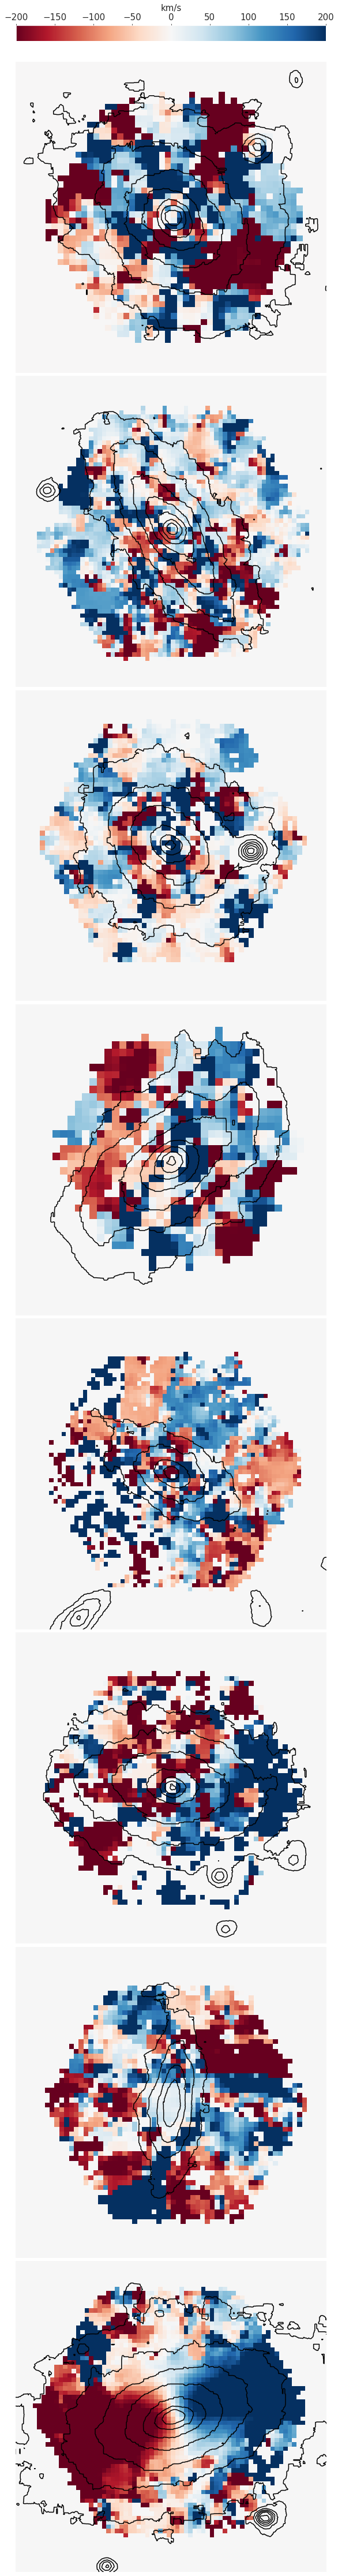

In [111]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l = []
for i,mangaid in enumerate(ids_[:8]):

  maps = Maps(mangaid = mangaid ,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

  havel = maps['emline_gvel_ha_6564']
  data = havel
  
  ax = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
  img = ax.imshow(goodspax(data,type = 'vel', SNR = 0),
                  cmap = 'RdBu',
                  vmin = -200,vmax = 200)


  ax.grid(False)
  ax.set_autoscale_on(False)
  ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax.axis('off')
  ax_l.append(ax)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.07))
cb.set_label('km/s')
plt.subplots_adjust(hspace = 0.01)

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcc9f61b510>)

[WARNING]: Warning: converting a masked element to nan. (UserWarning)
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)

[WARNING]: Warning: converting a masked element to nan. (UserWarning)

[WARNING]: Warning: converting a masked element to nan. (UserWarning)
  data = np.asarray(value)



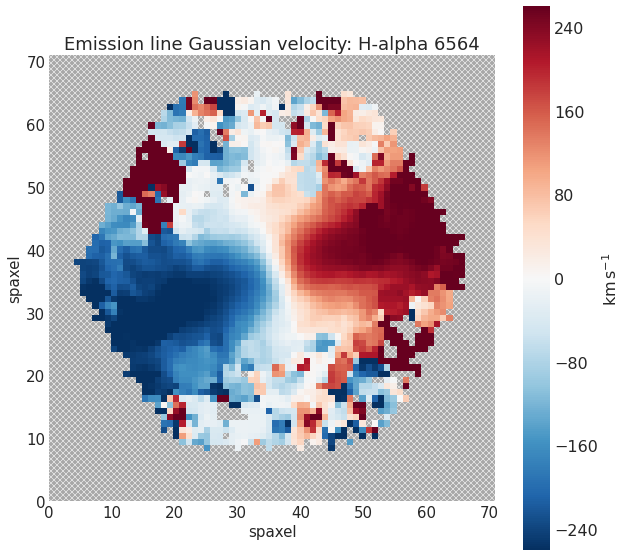

In [105]:
havel.plot()

### **Stellar velocity**

[WARNING]: drpall file not found. Downloading it. (MarvinUserWarning)
  warnings.warn('{0} file not found. Downloading it.'.format(name), MarvinUserWarning)

Progress: 100%|██████████| 1/1 [00:05<00:00,  5.01s/files, n_files=1, n_streams=1]


SDSS_ACCESS> Done!
  Kin PA:   2.0  +/-  44.3  (3*sigma error)
Velocity Offset: 0.00


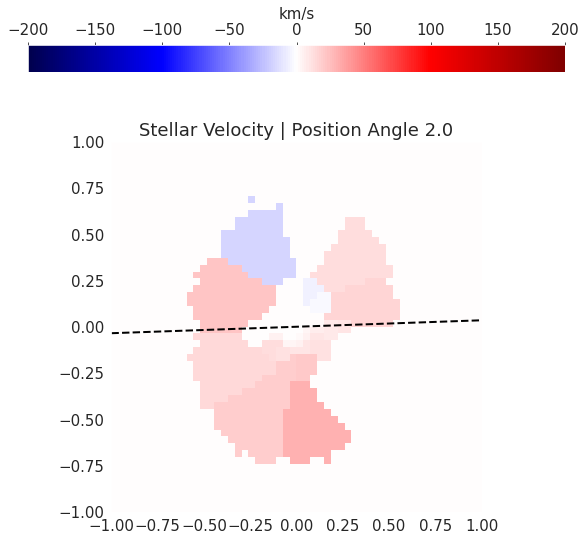

In [ ]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8)
ax_l = []
for i,mangaid in enumerate(ids[:5]):

  maps = Maps(mangaid = mangaid ,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

  stvel= maps['stellar_vel']
  data = stvel
  
  ax = fig.add_subplot(gs[i],projection=maps.wcs,slices=('x','y',0))
  img = ax.imshow(goodspax(data,type = 'vel', SNR = 0), cmap = 'seismic',
                  vmin = -200,vmax = 200)


  ax.grid(False)
  ax.set_autoscale_on(False)
  ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
  ax.axis('off')
  ax_l.append(ax)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.1))
cb.set_label('km/s')
plt.subplots_adjust(hspace = 0.01)

In [ ]:
114   - 126.5

-12.5

Text(0, 0.5, 'kpc')

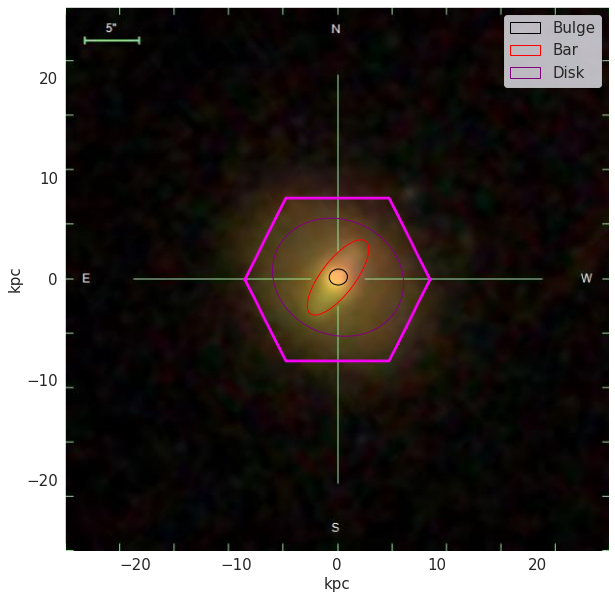

In [ ]:
# SDSS
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.grid(False)
ax1.imshow(optical.data, extent = (-r,r,-r,r))
ax1.grid(False)
apertures = aperture_gen(mods[:-1],0.5*dist_scale,r, 
                         origin = 'center', a_offset = 20)
for k, aperture in enumerate(apertures):
  apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
ax1.legend()
ax1.set_xlabel('kpc')
ax1.set_ylabel('kpc')

In [108]:
sb.color_palette()

<function seaborn.palettes.color_palette(palette=None, n_colors=None, desat=None, as_cmap=False)>

# **Position Angle**

#### **H-alpha Velocity** 

DEBUG:marvin:local mode failed. Trying remote now.


  Kin PA: 170.0  +/-   0.5  (3*sigma error)
Velocity Offset: 0.00


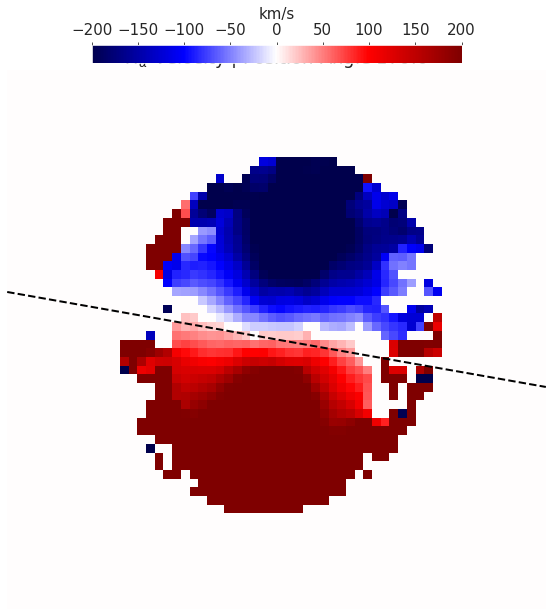

In [102]:
fig = plt.figure(figsize = (30,120))
gs  = gridspec.GridSpec(ncols=1, nrows=12,)
ax_l = []
for i,mangaid in enumerate(ids_[21:22]):

  maps = Maps(mangaid = mangaid ,mode='remote')
  plateifu = maps.plateifu

  # Set the size of image cutout 
  scale = maps.wcs.to_header()['PC2_2']*3600
  size = 2*maps.wcs.to_header()['CRPIX1']*scale

  # Get SDSS Image
  optical=maps.getImage()

  # Crop Image to match IFU size

  optical.get_new_cutout(size,size,size/512)
  filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
  levels=[60.,  90., 120., 150., 180., 210., 240.]

  havel = maps['emline_gvel_ha_6564']
  data = havel
  
  ax = fig.add_subplot(gs[i])

  R   = maps.spx_ellcoo_elliptical_radius.value/float(maps.header['reff'])
  mask = R > 1.5

  mask  = np.where(mask==True,1e-32,1)

  img = ax.imshow(goodspax(data,type = 'vel', SNR = 3)*mask, extent = [-1,1,-1,1],
                  cmap = 'seismic', origin = 'lower',vmin = -200,vmax = 200)


  size = data.value.shape[0]//2
  x,y  = np.mgrid[-size:size, -size:size]//2
  

  out1  = paf.fit_kinematic_pa(x,y,goodspax(data*mask,type = 'vel', SNR = 3).T, plot = False)
  ax.set_title(r'$H_{\alpha}$ Velocity | ' + f'Position Angle {out1[0]}')
  ax.set_ylim(-1,1)

  x    = np.linspace(-1,1,10)
  y    = np.tan(np.pi/180*out1[0])*x
  ax.plot(x,y, '--',color = 'black', linewidth =2) 
  ax.axis('off')
  ax_l.append(ax)
cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.221, anchor = (0.5,1.5))
cb.set_label('km/s')
plt.subplots_adjust(hspace = 0.01)

In [82]:
34-12

22

### **Stellar velocity**

[WARNING]: drpall file not found. Downloading it. (MarvinUserWarning)
  warnings.warn('{0} file not found. Downloading it.'.format(name), MarvinUserWarning)

Progress: 100%|██████████| 1/1 [00:05<00:00,  5.01s/files, n_files=1, n_streams=1]


SDSS_ACCESS> Done!
  Kin PA: 169.5  +/-   2.0  (3*sigma error)
Velocity Offset: 0.00


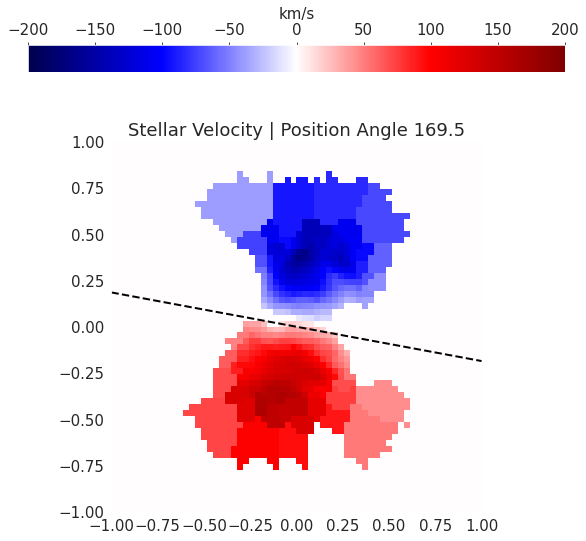

In [103]:
fig = plt.figure(figsize = (30,80))
gs  = gridspec.GridSpec(ncols=1, nrows=8,)
ax_l = []
for i,mangaid in enumerate(ids_[21:22]):

  maps = Maps(mangaid = mangaid ,mode='remote')
  plateifu = maps.plateifu
    
  stvel = maps['stellar_vel']
  data = stvel

  ax = fig.add_subplot(gs[i])

  R   = maps.spx_ellcoo_elliptical_radius.value/float(maps.header['reff'])
  mask = R > 3
  mask  = np.where(mask==True,1e-32,1)
  data= data*mask

  img = ax.imshow(goodspax(data,type = 'vel',SNR = 3), cmap = 'seismic',extent =[-1,1,-1,1], origin = 'lower',vmin = -200,vmax = 200)
  size = data.value.shape[0]//2
  x,y  = np.mgrid[-size:size, -size:size]//2
  out2  = paf.fit_kinematic_pa(x,y,goodspax(data,type = 'vel', SNR = 3).T, plot = False)
  ax.set_title(f'Stellar Velocity | Position Angle {out2[0]}')
  x    = np.linspace(-1,1,10)
  y    = np.tan(np.pi/180*out2[0])*x
  ax.plot(x,y, '--',color = 'black', linewidth = 2) 
  ax.set_ylim(-1,1)
  ax_l.append(ax)

cb=plt.colorbar(img,ax=ax_l,location = 'top', shrink=0.321, anchor = (0.5,1.1))
cb.set_label('km/s')

In [90]:
mangaid

'1-115377'

Text(0, 0.5, 'kpc')

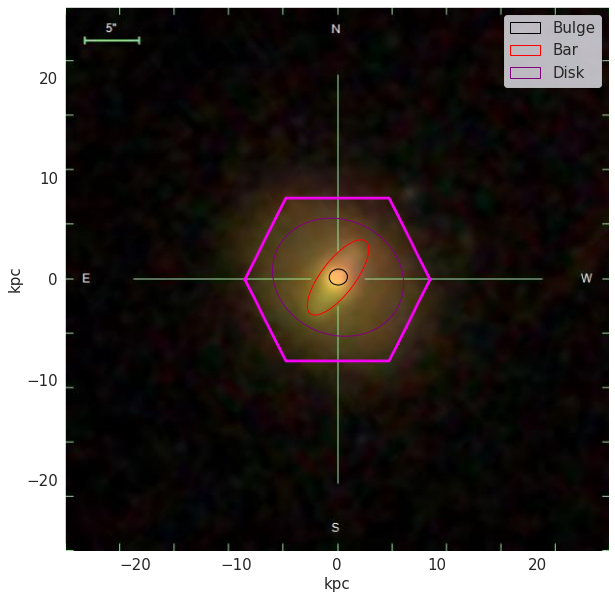

In [ ]:
# SDSS
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.grid(False)
ax1.imshow(optical.data, extent = (-r,r,-r,r))
ax1.grid(False)
apertures = aperture_gen(mods[:-1],0.5*dist_scale,r, 
                         origin = 'center', a_offset = 20)
for k, aperture in enumerate(apertures):
  apertures[aperture].plot(ax1,color = colors_[k], label = models[k])
ax1.legend()
ax1.set_xlabel('kpc')
ax1.set_ylabel('kpc')

# **MaNGA Cube animation**

In [41]:
maps = Maps(plateifu='9181-9101',mode='remote')

In [ ]:
cube = maps.getCube()

In [ ]:
flux = cube.flux
y    = flux.value
x    = flux.wavelength.value

In [ ]:
!mkdir images

In [ ]:
for i in range(220):
  fig = plt.figure(figsize = (25,8))
  gs = gridspec.GridSpec(1,2,width_ratios=[1,2]) 
  ax1 = fig.add_subplot(gs[0],projection = cube.wcs, slices = ('x','y',0))
  ax2 = fig.add_subplot(gs[1])
  im = ax1.imshow(y[i*20], cmap= 'jet')
  pl = ax2.plot(x,y.sum(axis=(1,2)), color ='purple')
  ax2.set_ylim(0,500)
  y_l = np.linspace(0,500,10)
  x_l = y_l*0 + x[i*20]
  ax2.plot(x_l,y_l, color ='black')
  ax2.set_ylabel(r'Flux [1x$10^{-17}]$ $ergs/s/cm^2$')
  ax2.set_xlabel('Wavelength [Å]')
  fig.savefig(f'images/img{i}.png')
  plt.close()

In [ ]:
!mkdir images

In [ ]:
writer = anim.FFMpegWriter(
    fps=1, metadata=dict(artist='Me'), bitrate=1800)
ani.save("movie.mp4", writer=writer)